# Create Enviornment

## Imports and Function Declarations

In [1]:
import numpy as np
from scipy import interpolate
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib

In [2]:
ctr = np.array( [(5 , 2), (2.5, 4), (0, 0), (-2.5, 4),
                (-3, 0), (-2.5, -4), (5, -2),])
ctrO = ctr.copy()
p = 3 #degree
midpoints = [1]*(len(ctr)-1)
res = 1000 #sample resolution
Kmax = 5

In [3]:
def getArrayTrueRange(array):
    exceed_ranges = []
    exceeds = np.asarray(curvature > Kmax).nonzero()[0]
    if len(exceeds) == 0:
        return []
    se = exceeds[0]
    pe = False
    if len(exceeds)>1:
        for ei,e in enumerate(exceeds[1:]):
            #print(pe,e,ei,len(exceeds),ei == len(exceeds)-2)
            if pe and (e != pe+1 or ei == len(exceeds)-2):
                exceed_ranges.append((se,e))
                se = e
            pe = e
    return exceed_ranges

def createMidPoints(ctr, midpoints=1):
    if isinstance(midpoints,int):
        midpoints = np.array([midpoints]*(len(ctr)-1))
    else:
        midpoints = np.array(midpoints)
    assert len(midpoints)+1 == len(ctr), f"mp {len(midpoints)} | ctr {len(ctr)}"
    inserted_ctr = []
    if (midpoints > 0).any():
        newCtr = []
        for c1,c2,midpoint in zip(ctr[:-1],ctr[1:], midpoints):
            newCtr.append(c1)
            inserted_ctr_m = [(c1*(midpoint-m)+c2*(m+1))/(midpoint+1) for m in range(midpoint)]
            inserted_ctr += inserted_ctr_m
            newCtr += inserted_ctr_m
            
        newCtr.append(c2)
    else:
        newCtr = ctr
    newCtr, inserted_ctr = np.array(newCtr), np.array(inserted_ctr)
    return newCtr, inserted_ctr

def getBSpline(ctr):
    # uncomment both lines for a closed curve
    #x=np.append(x,[x[0]])  
    #y=np.append(y,[y[0]])

    l=len(ctr)  

    t=np.linspace(0,1,l-p+1,endpoint=True)
    t=np.append([0]*p,t)
    t=np.append(t,[1]*p)

    tck=[t,[ctr[:,0],ctr[:,1]],p]
    u=np.linspace(0,1,(max(l*2,res)),endpoint=True)
    return getOutsFromTck(u,tck)
    
def getOutsFromTck(u,tck):
    out = interpolate.splev(u,tck)
    cx,cy = interpolate.splev(u,tck,der=1)
    cxx,cyy = interpolate.splev(u,tck,der=2)
    curvature = np.abs(((cx*cyy-cxx*cy)/((cx**2+cy**2)**(3/2))))
    return out, curvature

def getProblematicControlIndices(ctrO, bspline, curvature, Kmax=Kmax):
    exceed_ranges = getArrayTrueRange(curvature > Kmax)

    problematicC = []
    for r in exceed_ranges:
        mind = r[0]+curvature[r[0]:r[1]].argmax()
        spline_coor = bspline[0][mind], bspline[1][mind]
        Cdistance = np.array([((spline_coor-c)**2).sum() for c in ctrO])
        nearestCIndex = Cdistance.argmin()
        problematicC.append(nearestCIndex)
        
    return problematicC

def plotPath(ctrO, inserted_ctr, bspline, newtitle=None, labels=None, show=True, axis=None):
    default_labels = ['Control polygon','Added midpoints','B-spline curve']
    
    if labels is None:
        labels = default_labels
    else:
        for (li,l),dl in zip(enumerate(labels),default_labels):
            if not l:
                labels[li] = dl
            
    zorder = 0
    
    plt.plot(ctrO[:,0],ctrO[:,1],'k--',label=labels[0],marker='o',markerfacecolor='tab:red', zorder=zorder)
    zorder += 1
    if len(inserted_ctr):
        plt.scatter(inserted_ctr[:,0],inserted_ctr[:,1],label=labels[1],marker='o',facecolor='tab:orange', edgecolor='black',zorder=zorder)
        zorder += 1
        x=np.concatenate((ctrO[:,0],inserted_ctr[:,0]))
        y=np.concatenate((ctrO[:,1],inserted_ctr[:,1]))
    else:
        x = ctrO[:,0]
        y = ctrO[:,1]
        
    plt.plot(bspline[0],bspline[1],'tab:blue',linewidth=2.0,label=labels[2], zorder=zorder)
    zorder += 1

    plt.legend(loc='best')
    if axis:
        plt.axis(axis)
    else:
        plt.axis([min(x)-1, max(x)+1, min(y)-1, max(y)+1])
    if newtitle:
        plt.title(newtitle)
    else:
        plt.title('B-spline Approximation Curve')
        
    plt.grid()
    if show:
        plt.show()
    
def plotCurvature(curvature, Kmax=Kmax, plot=True):
    zorder = 0
    plt.plot(np.linspace(0,1,len(curvature)), curvature,'tab:blue',linewidth=2.0,label='Curvature', zorder=zorder)
    plt.axhline(y=Kmax, color='tab:red', label='$K_{max}$')

    plt.legend(loc='best')
    plt.title('Curvature Magnitude')
    plt.xlabel('Normalized Path Length $u$')
    plt.ylabel('Curvature $|k(u)|$')
    plt.ylim(0,max(Kmax,curvature.max())+0.5)
    plt.grid()
    if plot:
        plt.show()

## Create Path

In [241]:
ctr,inserted_ctr = createMidPoints(ctrO,midpoints=midpoints)
bspline, curvature = getBSpline(ctr)

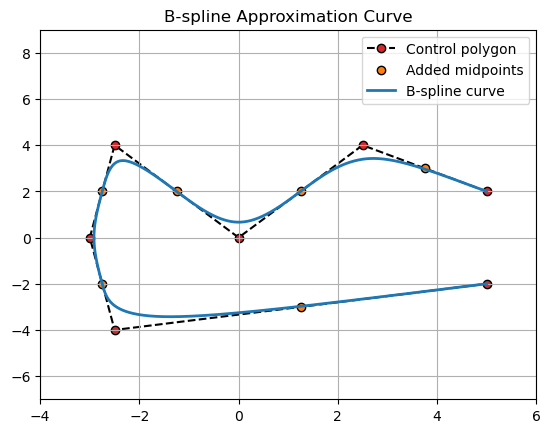

In [247]:
bapprox = plotPath(ctrO, inserted_ctr, bspline,axis=[-4,6,-7,9])
#bapprox = plotPath(ctrO, [], bspline, axis=[-4,6,-7,9])

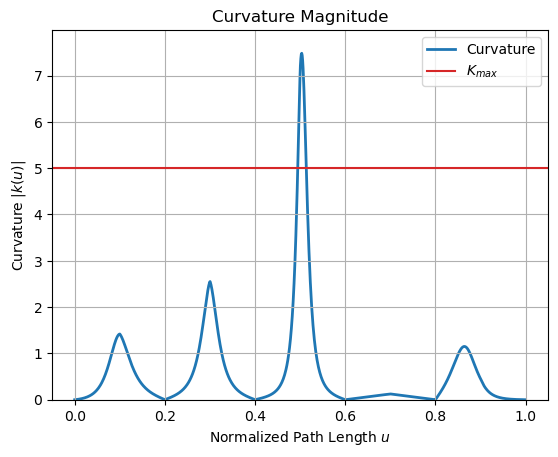

In [242]:
plotCurvature(curvature)

# Solutions

## Solution 1: remove midway points

In [124]:
ctr,inserted_ctr = createMidPoints(ctrO,midpoints=midpoints)
bspline, curvature = getBSpline(ctr)

In [126]:
problematicControlIndices = getProblematicControlIndices(ctrO, bspline, curvature)
print("Problematic control points:", ctrO[problematicControlIndices])

Problematic control points: [[-2.5  4. ]]


In [128]:
new_midpoints = midpoints.copy()
for pi in problematicControlIndices:
    if pi > 0:
        new_midpoints[pi-1] = 0
    if pi < len(new_midpoints)-1:
        new_midpoints[pi] = 0
        
print("New midpoints:", new_midpoints)

New midpoints: [1, 1, 0, 0, 1, 1]


In [130]:
ctr,inserted_ctr = createMidPoints(ctrO,midpoints=new_midpoints)
bspline, curvature = getBSpline(ctr)

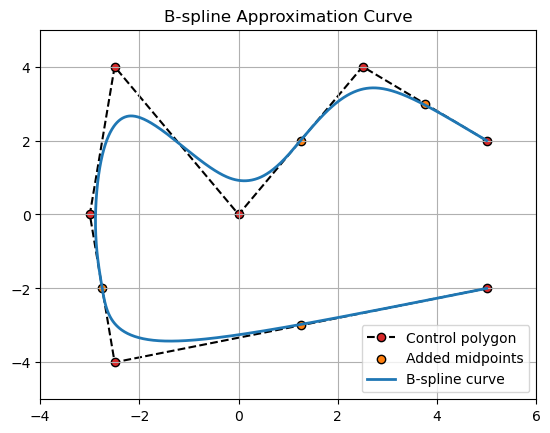

In [132]:
plotPath(ctrO, inserted_ctr, bspline)

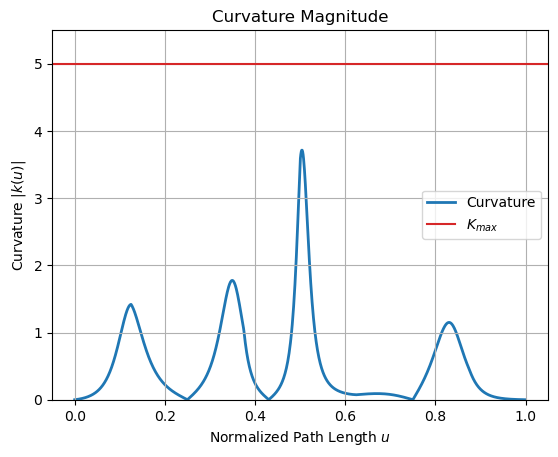

In [134]:
plotCurvature(curvature)

## Solution 2: move problematic control point
"Single-Peak Solution" from "Solutions for Path Planning Using Spline"

In [137]:
res_search = 0.01

In [139]:
ctr,inserted_ctr = createMidPoints(ctrO,midpoints=midpoints)
bspline, curvature = getBSpline(ctr)

In [141]:
problematicControlIndices = getProblematicControlIndices(ctrO, bspline, curvature)
print("Problematic control points:", ctrO[problematicControlIndices])

Problematic control points: [[-2.5  4. ]]


In [143]:
def ClosestPointAlongLine(p1, p2, p3):
    #find closest point from p3 along line (p1,p2)
    x1, y1 = p1
    x2, y2 = p2
    x3, y3 = p3
    dx, dy = x2-x1, y2-y1
    det = dx*dx + dy*dy
    a = (dy*(y3-y1)+dx*(x3-x1))/det
    return np.array([x1+a*dx, y1+a*dy])

In [145]:
for p in problematicControlIndices:
    assert p > 0 and p < len(ctrO)-1
    goalp = ClosestPointAlongLine(ctrO[p-1],ctrO[p+1],ctrO[p])
    for l in np.arange(res_search,1+res_search,res_search):
        newp = np.array(goalp*l) + ctrO[p]*(1-l)
        newCtrO = ctrO.copy()
        newCtrO[p] = newp
        ctr,inserted_ctr = createMidPoints(newCtrO,midpoints=midpoints)
        bspline, curvature = getBSpline(ctr)
        new_problematicControlIndices = getProblematicControlIndices(newCtrO, bspline, curvature)
        if p not in new_problematicControlIndices:
            break

In [147]:
ctr,inserted_ctr = createMidPoints(newCtrO,midpoints=midpoints)
bspline, curvature = getBSpline(ctr)

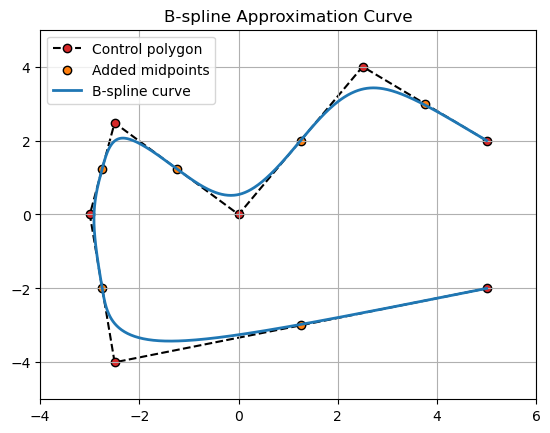

In [149]:
plotPath(newCtrO, inserted_ctr, bspline)

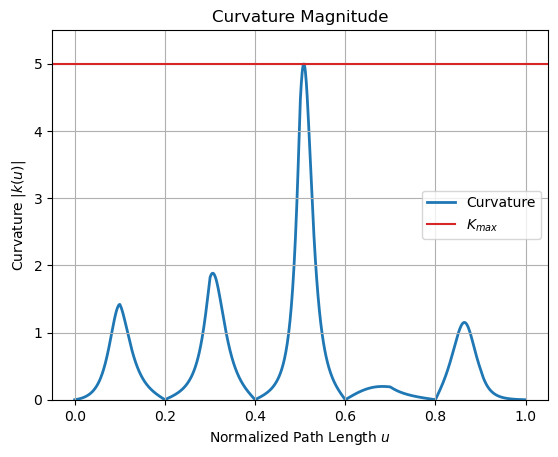

In [151]:
plotCurvature(curvature)

## Solution 3: Turn single control point into two for smoothing
"Double-Peak Solution" from "Solutions for Path Planning Using Spline" <br>
Implemented differently from solution for coding-laziness purposes without taking efficiency into account <br>
Problems with algorithm: bmin is just min(b). Doesn't address possibility of new waypoints ruining previous and preceding waypoint curvature

In [154]:
res_search = 0.01

In [156]:
ctr,inserted_ctr = createMidPoints(ctrO,midpoints=midpoints)
bspline, curvature = getBSpline(ctr)

In [158]:
problematicControlIndices = getProblematicControlIndices(ctrO, bspline, curvature)
print("Problematic control points:", ctrO[problematicControlIndices])

Problematic control points: [[-2.5  4. ]]


In [160]:
def newBScenario(b, ctrO, midpoints):
    newCtrO = ctrO.copy()
    new_midpoints = midpoints.copy()
    new_midpoints[p-1] = new_midpoints[p] = 0
    newCtrO[p] = p2 = b*ctrO[p-1] + (1-b)*ctrO[p]
    r = (((ctrO[p+1] - ctrO[p])**2).sum()/((ctrO[p] - ctrO[p-1])**2).sum())**(0.5)
    p4 = b*ctrO[p+1] + (1-b)*ctrO[p]
    p3 = (p4-p2)*r/(r+1)+p2
    newCtrO = np.insert(newCtrO, p+1, p4, axis=0)
    newCtrO = np.insert(newCtrO, p+1, p3, axis=0)
    new_midpoints = np.insert(new_midpoints, p, 0)
    new_midpoints = np.insert(new_midpoints, p, 0)
    return newCtrO, new_midpoints

In [162]:
possible_bs = []
for p in problematicControlIndices:
    assert p > 0 and p < len(ctrO)-1
    for b in np.arange(res_search,1,res_search):
        newCtrO, new_midpoints = newBScenario(b, ctrO, midpoints)
        
        ctr,inserted_ctr = createMidPoints(newCtrO,midpoints=new_midpoints)
        bspline, curvature = getBSpline(ctr)
        new_problematicControlIndices = getProblematicControlIndices(newCtrO, bspline, curvature)
        if sum([pi in new_problematicControlIndices for pi in range(p-1,p+4)]) == 0:
            possible_bs.append(b)

In [164]:
L0 = (((ctrO[p+1] - ctrO[p-1])**2).sum())**0.5
L1 = (((ctrO[p] - ctrO[p-1])**2).sum())**0.5
L2 = (((ctrO[p+1] - ctrO[p])**2).sum())**0.5
minb = min(possible_bs, key=lambda b: b*(L1+L2-L0)+L0)

In [166]:
newCtrO, new_midpoints = newBScenario(minb, ctrO, midpoints)

In [168]:
npc = getProblematicControlIndices(newCtrO, bspline, curvature)

In [170]:
ctr,inserted_ctr = createMidPoints(newCtrO,midpoints=new_midpoints)
bspline, curvature = getBSpline(ctr)

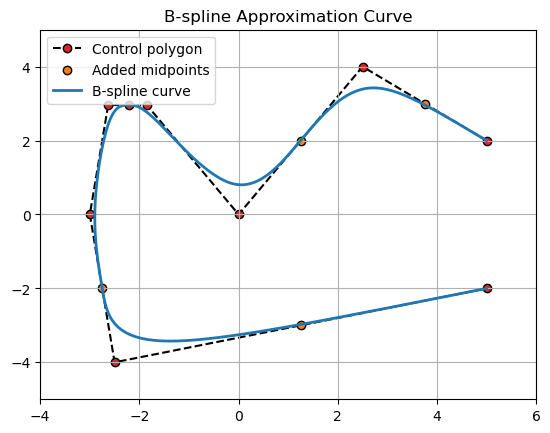

In [172]:
plotPath(newCtrO, inserted_ctr, bspline)

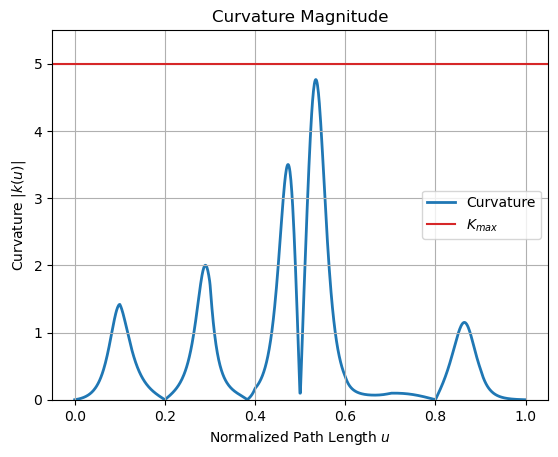

In [174]:
plotCurvature(curvature)

## Interpolation

In [14]:
cx = [1,3,5,7,9,11,13]
cy = [2, 4, 0, 4, 0, -4, -2]
cx,cy = np.array(cx), np.array(cy)
cc=np.vstack((cx,cy)).T

In [16]:
cx = [1,3,5,7,9]
cy = [0,5,3,7,5]
cx = ctrO[:,0]
cy = ctrO[:,1]

cx,cy = np.array(cx), np.array(cy)
cc=np.vstack((cx,cy)).T

s = 2
tck,_ = interpolate.splprep(cc.T,k=3,s=s)
u=np.linspace(0,1,num=1001,endpoint=True)
bspline, curvature = getOutsFromTck(u,tck)

In [18]:
np.array(bspline).T

array([[ 4.98572496,  2.14090143],
       [ 4.95977051,  2.18817814],
       [ 4.93390672,  2.23466524],
       ...,
       [ 4.9014076 , -2.12146065],
       [ 4.94971837, -2.05734781],
       [ 4.99821314, -1.9926748 ]])

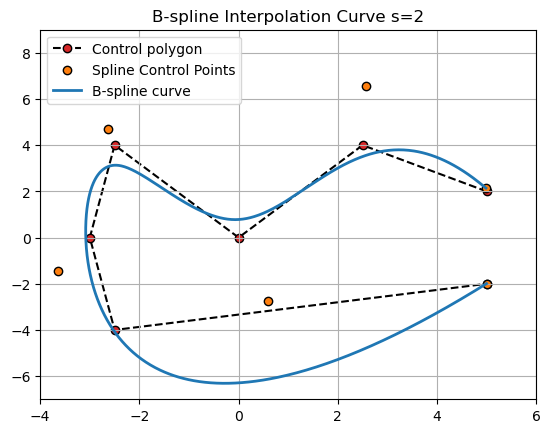

In [20]:
plotPath(cc, np.array(tck[1]).T, bspline, newtitle=f'B-spline Interpolation Curve s={s}', labels=[None,'Spline Control Points',None], axis=[-4,6,-7,9], show=False)
#plt.plot(bapprox[0],bapprox[1], color='tab:green', label='B approx')
#plt.legend()
plt.show()

In [28]:
tck[0], tck[0].shape, tck[1][0].shape

(array([0.        , 0.        , 0.        , 0.        , 0.27823555,
        0.44397726, 0.58561973, 1.        , 1.        , 1.        ,
        1.        ]),
 (11,),
 (7,))

In [251]:
ctrO

array([[ 5. ,  2. ],
       [ 2.5,  4. ],
       [ 0. ,  0. ],
       [-2.5,  4. ],
       [-3. ,  0. ],
       [-2.5, -4. ],
       [ 5. , -2. ]])

In [171]:
newC = np.array(tck[1]).T
ctr,inserted_ctr = createMidPoints(newC,midpoints=[1]*(len(newC)-1))
#bspline, curvature = getOutsFromTck(u,tck)

In [173]:
np.array(tck[1]).T

array([[ 5.        ,  2.        ],
       [ 2.35368623,  8.58601898],
       [ 0.94716476, -5.76027054],
       [-2.89225491,  6.87105998],
       [-3.18023997, -4.94674652],
       [-2.30156638, -6.63748478],
       [ 5.        , -2.        ]])

In [175]:
ctr

array([[ 5.        ,  2.        ],
       [ 3.67684312,  5.29300949],
       [ 2.35368623,  8.58601898],
       [ 1.6504255 ,  1.41287422],
       [ 0.94716476, -5.76027054],
       [-0.97254507,  0.55539472],
       [-2.89225491,  6.87105998],
       [-3.03624744,  0.96215673],
       [-3.18023997, -4.94674652],
       [-2.74090317, -5.79211565],
       [-2.30156638, -6.63748478],
       [ 1.34921681, -4.31874239],
       [ 5.        , -2.        ]])

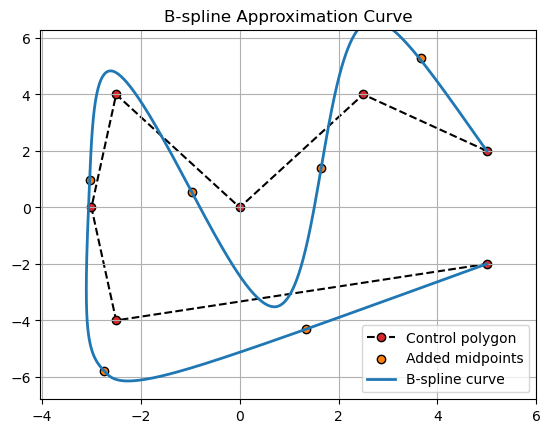

In [177]:
bspline, curvature = getBSpline(ctr)
bapprox = plotPath(ctrO, inserted_ctr, bspline)

In [21]:
cx,cy = interpolate.splev(u,tck,der=1)
cxx,cyy = interpolate.splev(u,tck,der=2)

In [47]:
tck[0] = [0,0,0,0,1,1,1,1]
nt = [1, 0.512208, 6.61438, 7, 2.4861e-07, 14.631, -5.48521, 7]
tck[1] = np.array(nt).reshape(2,len(nt)//2)

In [50]:
u=np.linspace(0,1,num=res,endpoint=True)
#bspline = interpolate.splev(u,tck)
bspline, curvature = getOutsFromTck(u,tck)

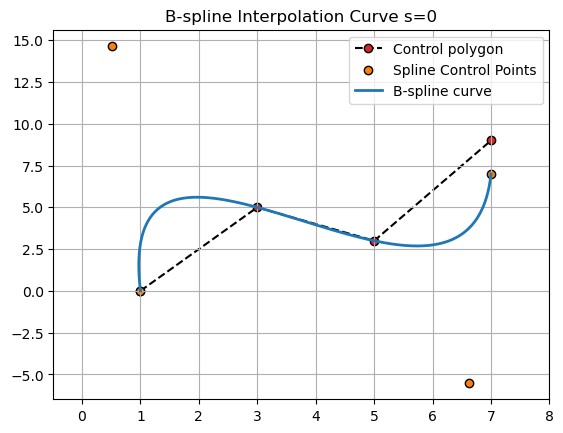

In [51]:
plotPath(cc, np.array(tck[1]).T, bspline, newtitle=f'B-spline Interpolation Curve s={s}', labels=[None,'Spline Control Points',None], show=False)

In [197]:
ctr = ctrO
s = 0
tck,_ = interpolate.splprep(ctrO.T,k=3,s=s)
u=np.linspace(0,1,num=res,endpoint=True)
#bspline = interpolate.splev(u,tck)
bspline, curvature = getOutsFromTck(u,tck)

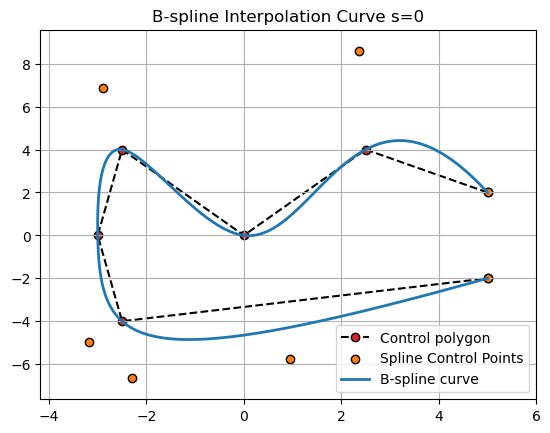

In [199]:
plotPath(ctr, np.array(tck[1]).T, bspline, newtitle=f'B-spline Interpolation Curve s={s}', labels=[None,'Spline Control Points',None], show=False)

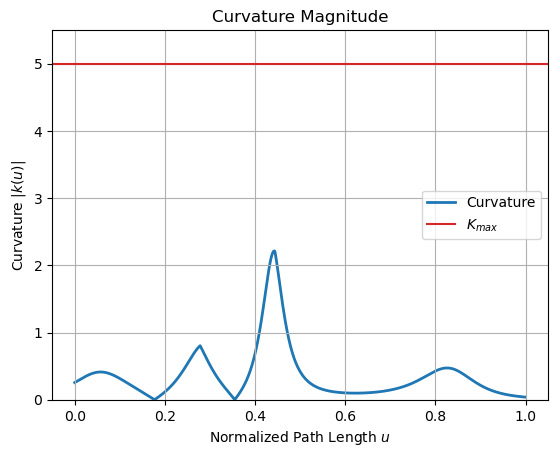

In [181]:
plotCurvature(curvature)

In [183]:
max(curvature)

2.213814840723697

In [986]:
import matplotlib.animation as animation
import glob
from PIL import Image

In [1071]:
files = []
ctr = ctrO#[-1]
axis = None
axis = [-1,60,-1,17.5]
axis = [-4,6,-7,9]
s = 0
ss = 0.5
for s in [2]:#np.arange(0,10+ss,ss):
    tck,_ = interpolate.splprep([ctr[:,0],ctr[:,1]],k=3,s=s)
    u=np.linspace(0,1,num=res,endpoint=True)
    bspline, curvature = getOutsFromTck(u,tck)
    #fig, axs = plt.subplots(1, 2, layout='constrained')
    plotPath(ctr, np.array(tck[1]).T, bspline, newtitle=f's={s}', labels=[None,'Spline Control Points',None], show=False, axis=axis)
    out_file = f"smooth_spline_animation/{s:.2f}"
    image_file = out_file + "o.png"
    cfile = out_file + "c.png"
    plt.savefig(image_file)
    plt.clf()
    files.append(image_file)
    '''plotCurvature(curvature, plot=False)
    plt.savefig(cfile)
    plt.clf()
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    fig.tight_layout()
    axs[0].imshow(plt.imread(image_file))
    axs[1].imshow(plt.imread(cfile))
    axs[0].axis('off')
    axs[1].axis('off')
    plt.suptitle(f's={s}')
    out_file += ".png"
    plt.savefig(out_file)
    files.append(out_file)
    plt.clf()'''

<Figure size 640x480 with 0 Axes>

In [1065]:
tck

[array([0.        , 0.        , 0.        , 0.        , 0.27823555,
        0.44397726, 0.58561973, 1.        , 1.        , 1.        ,
        1.        ]),
 [array([ 5.        ,  2.35368623,  0.94716476, -2.89225491, -3.18023997,
         -2.30156638,  5.        ]),
  array([ 2.        ,  8.58601898, -5.76027054,  6.87105998, -4.94674652,
         -6.63748478, -2.        ])],
 3]

In [1069]:
out = interpolate.splev([0.27823555],tck)
out

[array([-1.38186707e-09]), array([3.79801968e-10])]

In [1048]:
image_array = []
for my_file in files:
    image = Image.open(my_file)
    image_array.append(image)

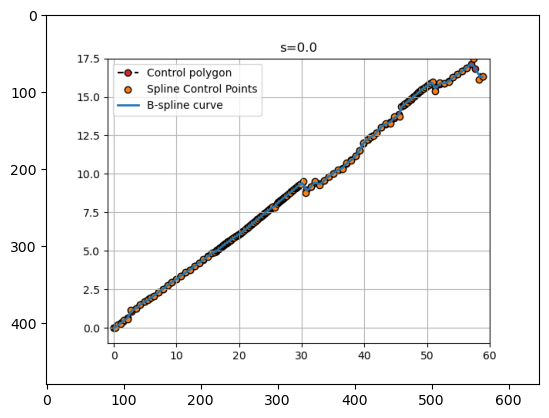

In [1049]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Create the figure and axes objects
fig, ax = plt.subplots()

# Set the initial image
im = ax.imshow(image_array[0], animated=True)

In [1050]:
def update(i):
    im.set_array(image_array[i])
    return im, 

In [1051]:
# Create the animation object
animation_fig = animation.FuncAnimation(fig, update, frames=len(image_array), interval=200, blit=True,repeat_delay=10,)

# Show the animation
plt.show()

animation_fig.save("smooth_spline_animation/animation.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.


151 Data points
s=0.0: 151 control points
s=0.5: 9 control points
s=1.0: 7 control points
s=1.5: 6 control points
s=2.0: 5 control points
s=2.5: 5 control points
s=3.0: 5 control points
s=3.5: 5 control points
s=4.0: 5 control points
s=4.5: 5 control points
s=5.0: 5 control points


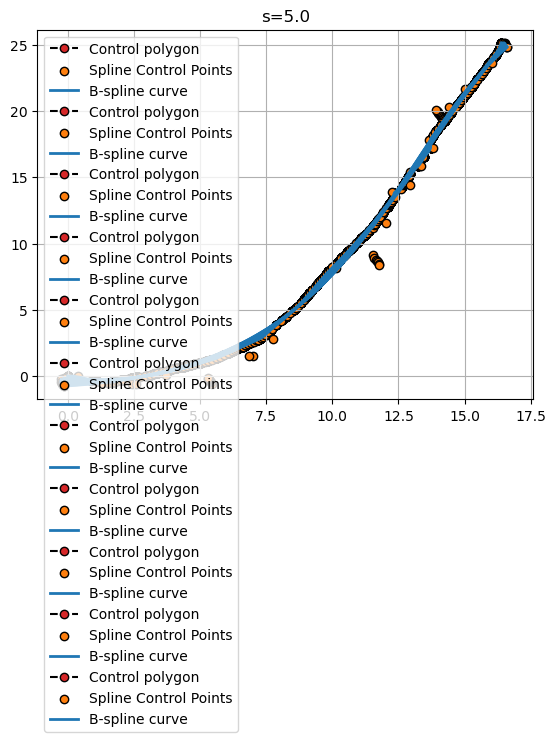

In [390]:
ctr = ctrs[50]
print(f"{len(ctr)} Data points")
for s in np.arange(0,5.5,0.5):
    tck,_ = interpolate.splprep([ctr[:,0],ctr[:,1]],k=3,s=s)
    print(f"s={s}: {len(tck[1][0])} control points")
    u=np.linspace(0,1,num=res,endpoint=True)
    bspline, curvature = getOutsFromTck(u,tck)
    #fig, axs = plt.subplots(1, 2, layout='constrained')
    bspline = plotPath(ctr, np.array(tck[1]).T, bspline, newtitle=f's={s}', labels=[None,'Spline Control Points',None], show=False)

s=2: 5 control points


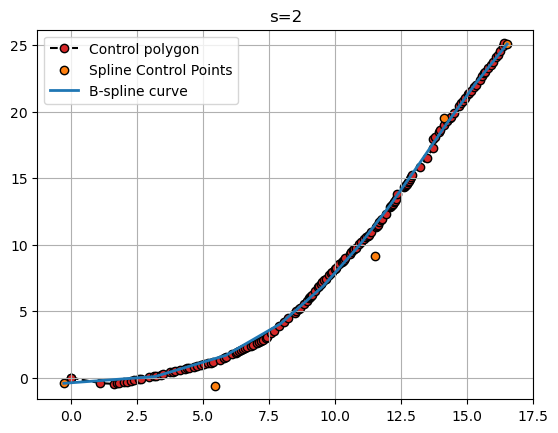

In [32]:
ctrOO = ctrs[50]
ctr = ctrs[50]
s=2
num_points = 11
tck,_ = interpolate.splprep([ctr[:,0],ctr[:,1]],k=3,s=s)
print(f"s={s}: {len(tck[1][0])} control points")
u=np.linspace(0,1,num=num_points,endpoint=True)
bspline, curvature = getOutsFromTck(u,tck)
#fig, axs = plt.subplots(1, 2, layout='constrained')
plotPath(ctr, np.array(tck[1]).T, bspline, newtitle=f's={s}', labels=[None,'Spline Control Points',None], show=False)

In [42]:
tck[1]

[array([-0.26380519,  5.45292327, 11.52413355, 14.12245978, 16.52038096]),
 array([-0.42219704, -0.62240001,  9.13580416, 19.52568839, 25.07422636])]

In [34]:
bspline

[array([-0.26380519,  3.1937541 ,  5.87185841,  7.93878601,  9.56281518,
        10.90854396, 12.0868596 , 13.16798526, 14.22113681, 15.31553009,
        16.52038096]),
 array([-0.42219704,  0.0870349 ,  1.68224032,  4.05458813,  6.89524725,
         9.90625903, 12.94834292, 16.00235228, 19.05211642, 22.08146467,
        25.07422636])]

In [36]:
curvature

array([0.0892019 , 0.12303826, 0.10245258, 0.06075814, 0.02890531,
       0.01530994, 0.00903232, 0.00239864, 0.00439793, 0.01120265,
       0.01776536])

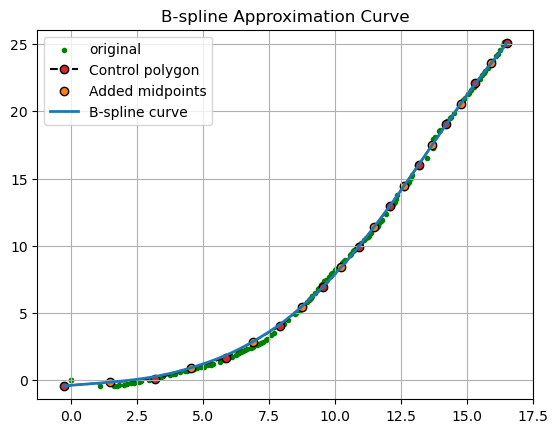

In [476]:
plt.scatter(ctrOO[:,0],ctrOO[:,1],marker='.',color='green',label='original',zorder=-1)
newC = np.array(bspline).T
ctr,inserted_ctr = createMidPoints(newC,midpoints=[1]*(newC.shape[0]-1))
bspline, curvature = getBSpline(ctr)
bapprox = plotPath(newC, inserted_ctr, bspline)
#bapprox = plotPath(ctrO, [], bspline, axis=[-4,6,-7,9])

In [372]:
newC.shape

(101, 2)

In [328]:
ctrO.shape

(7, 2)

In [13]:
paths[50]

'path1714051439995.csv'

In [8]:
import os
pathsdir = "paths"

def remove_all(s,chrs):
    for c in chrs:
        s = s.replace(c,"")
    return s
def parseCoorsFromPathFile(pathfile):
    f = open(pathfile,'r')
    fc = f.read()
    f.close()

    coors = fc.split("\n")
    coors = [remove_all(c,"[];").split(",") for c in coors]
    coors = [[float(ci.strip()) for ci in c] for c in coors]
    assert all([len(c) == 2 for c in coors])
    return coors

In [10]:
paths = os.listdir(pathsdir)
paths = paths[-100:]

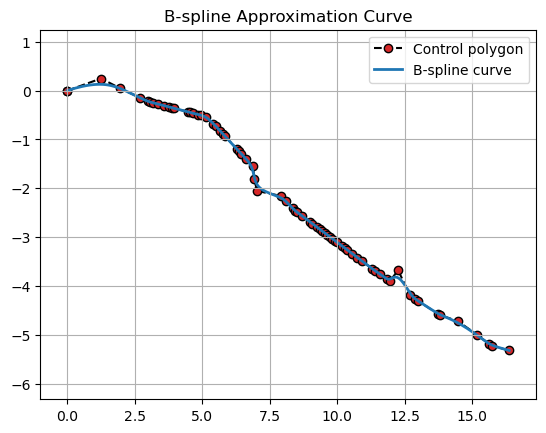

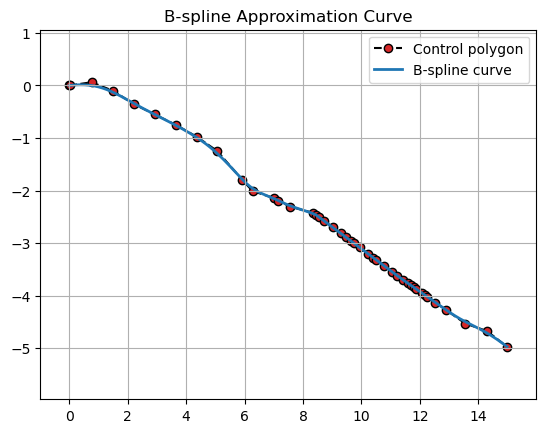

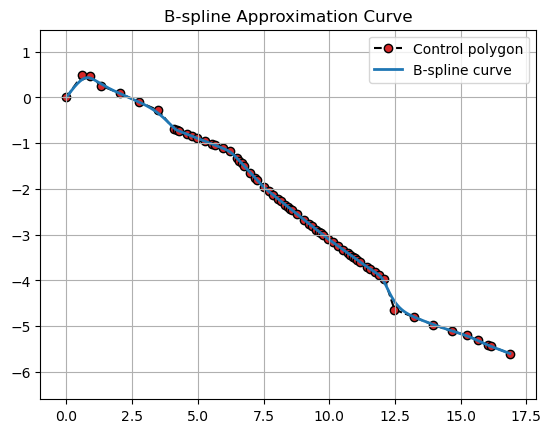

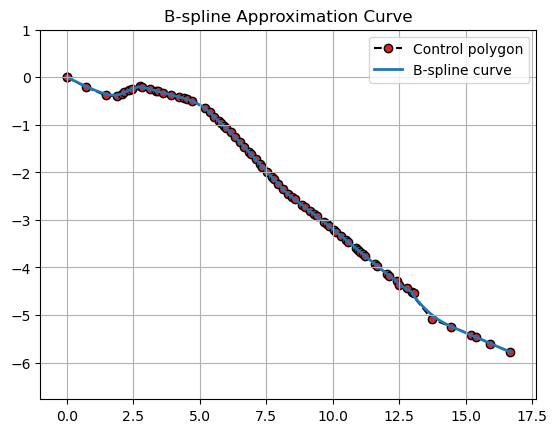

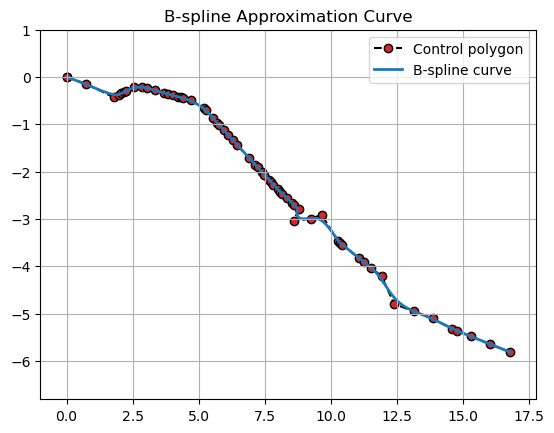

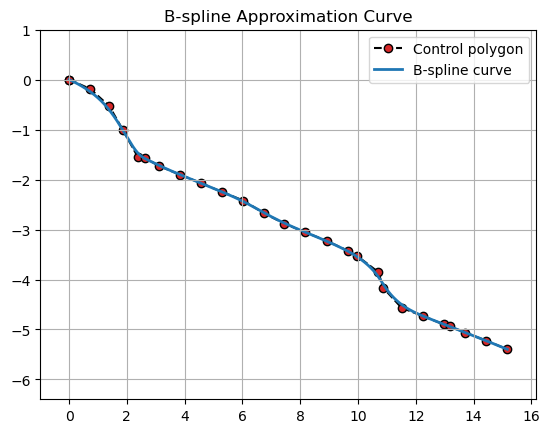

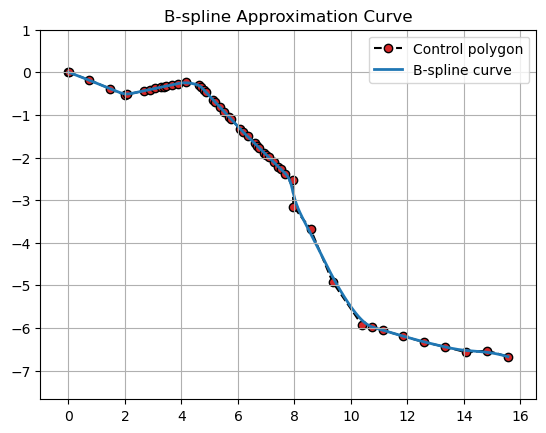

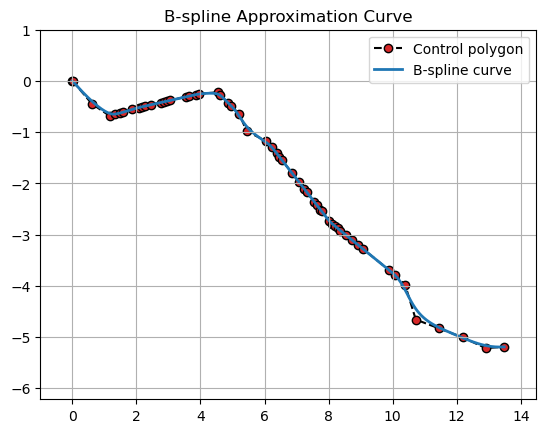

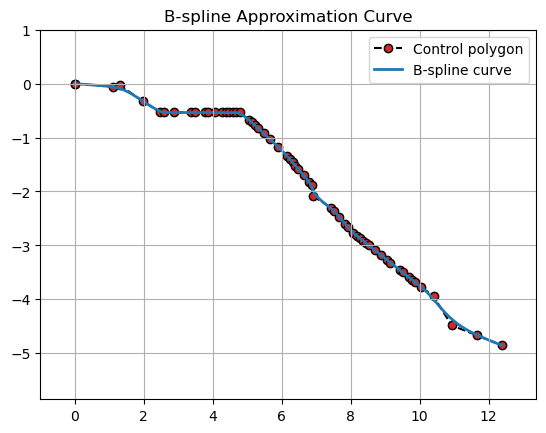

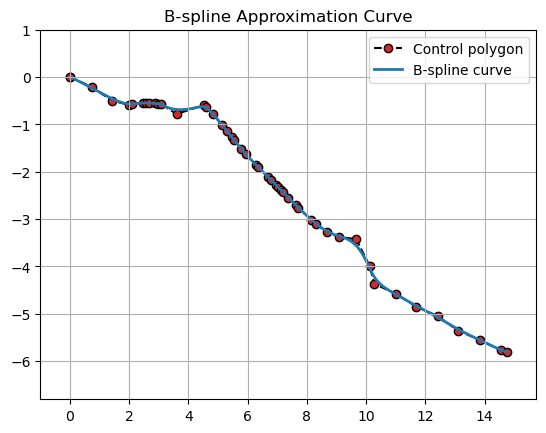

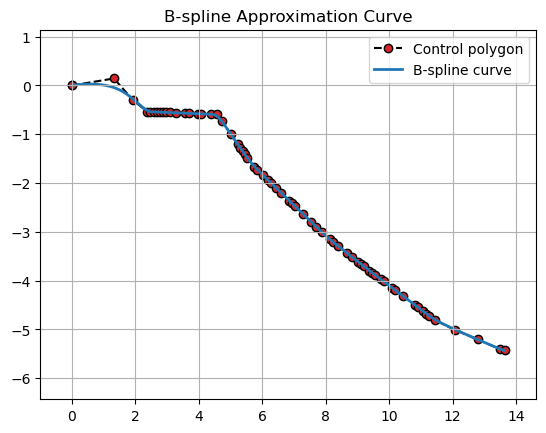

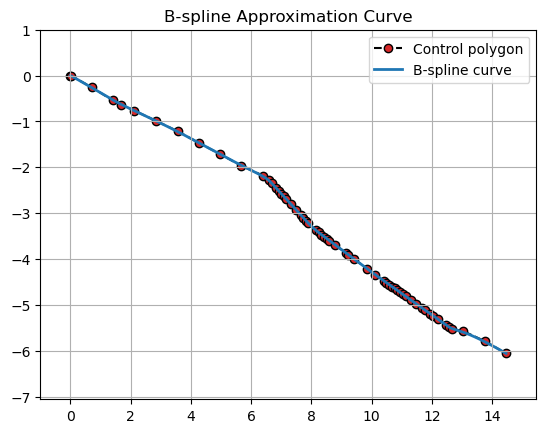

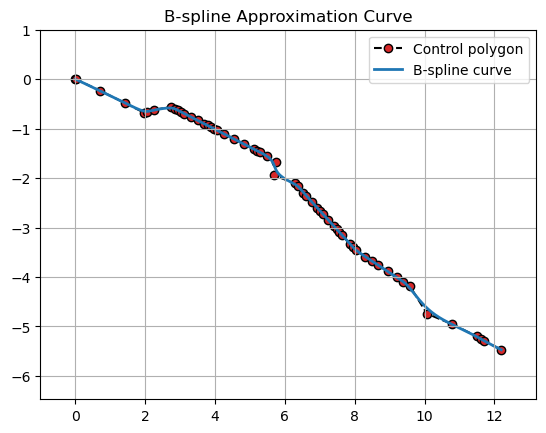

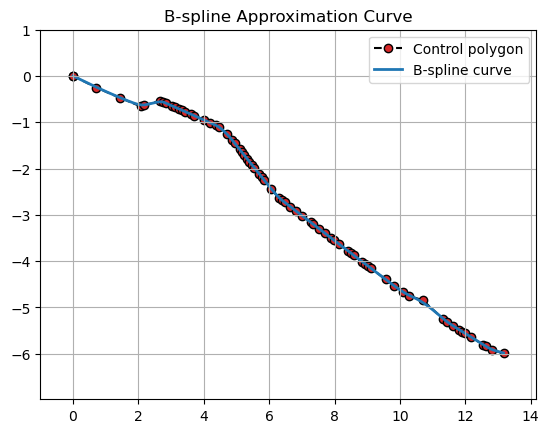

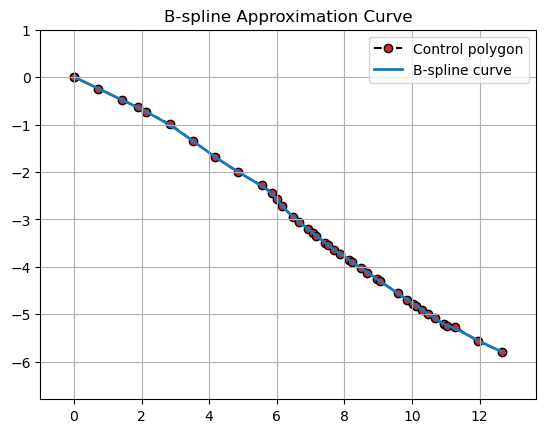

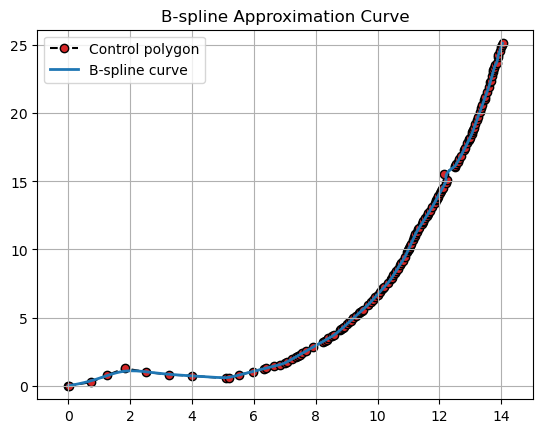

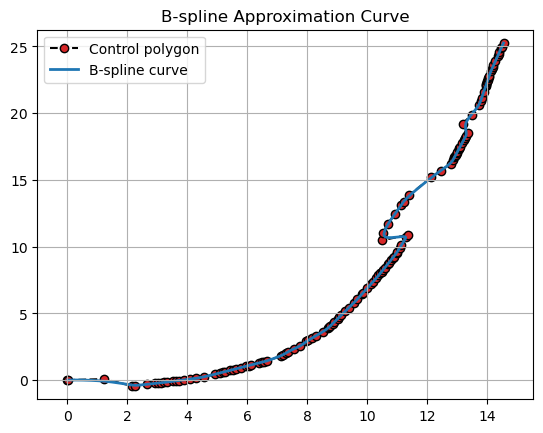

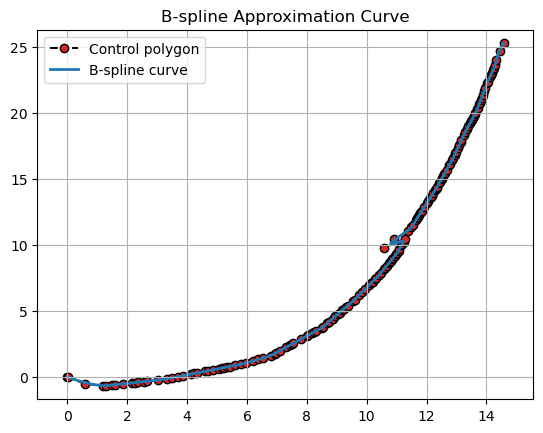

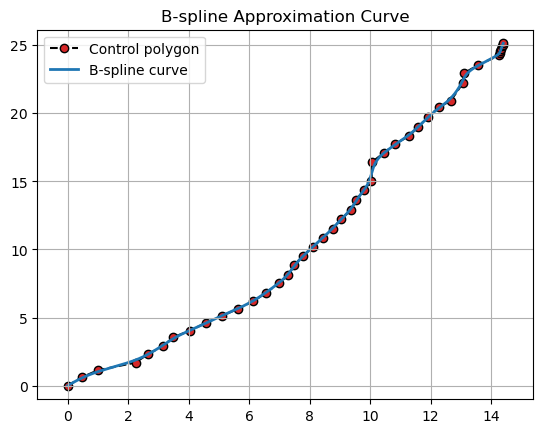

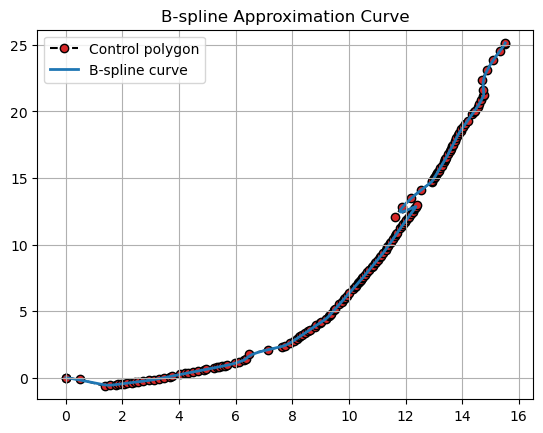

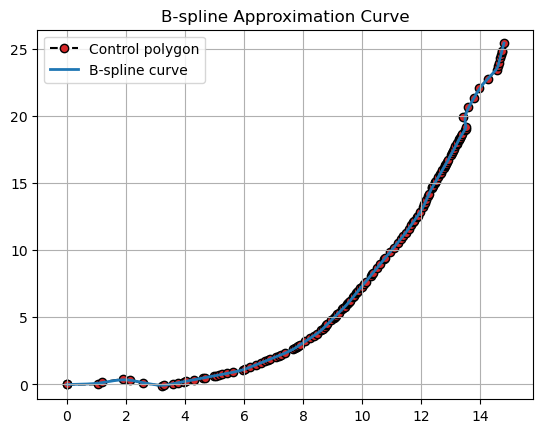

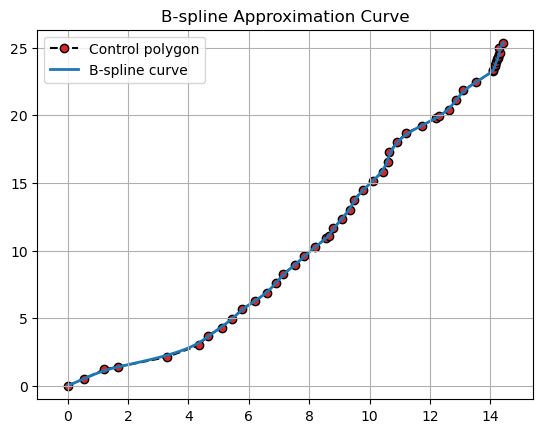

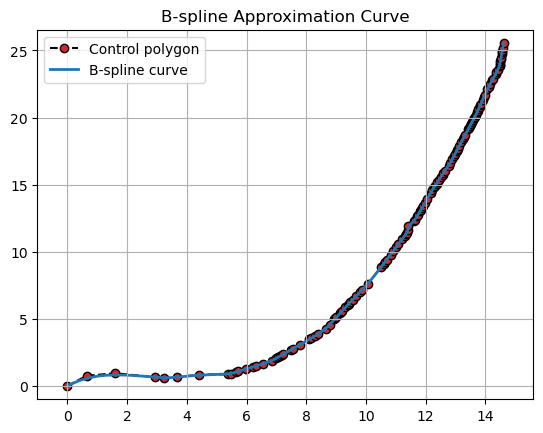

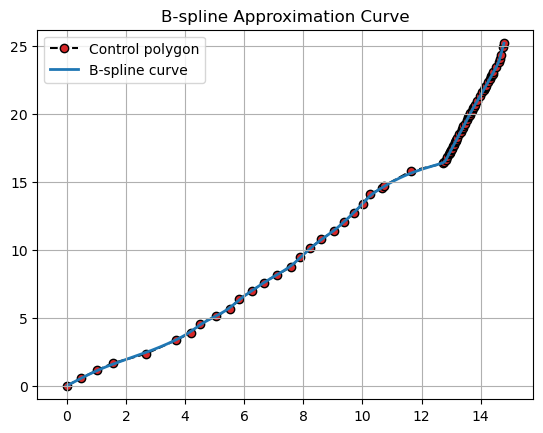

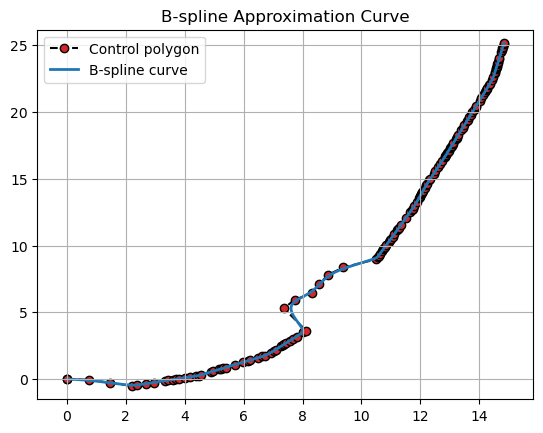

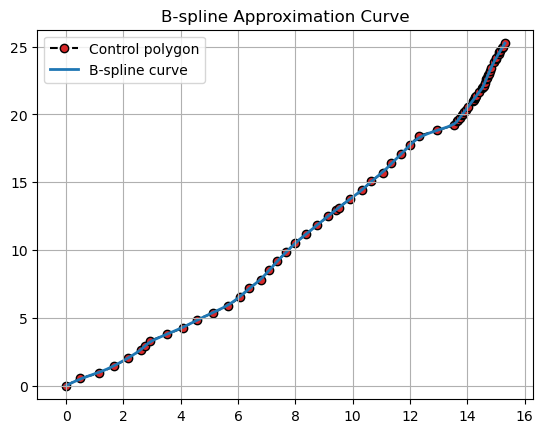

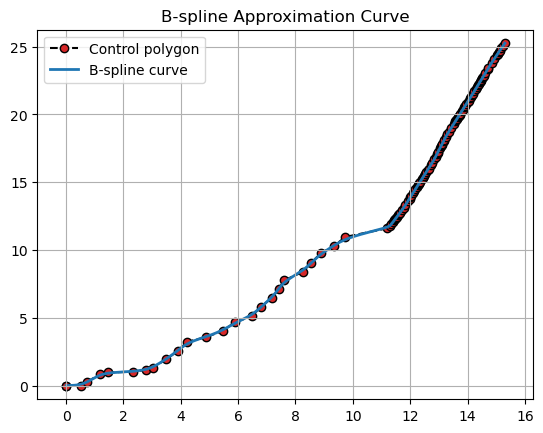

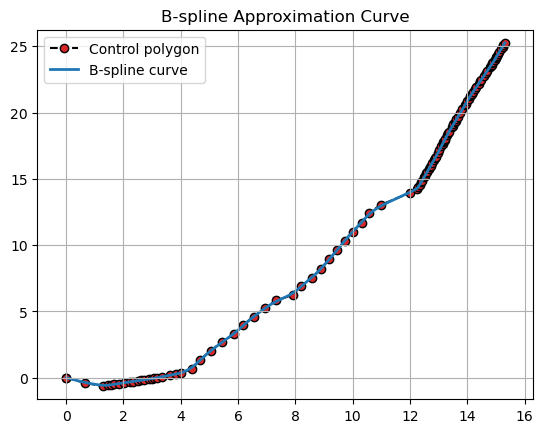

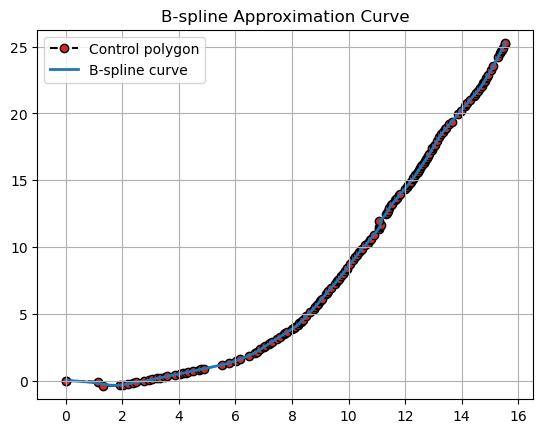

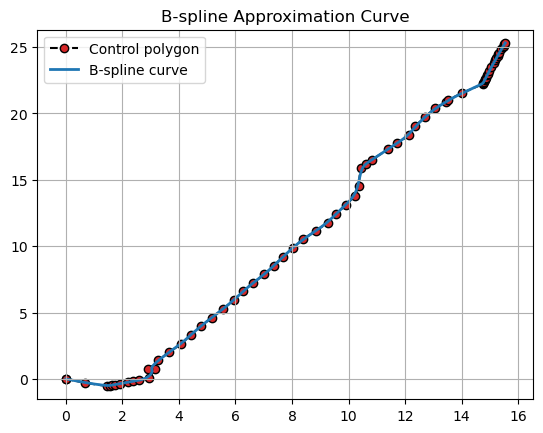

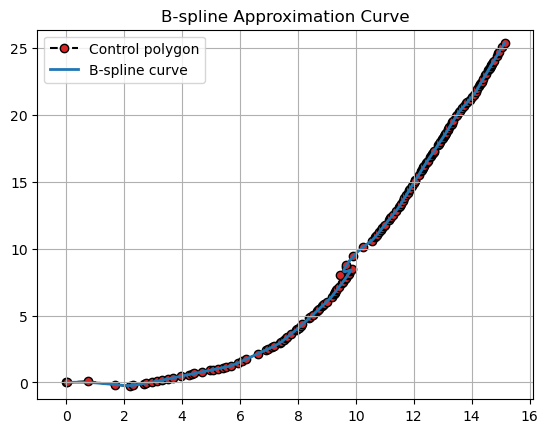

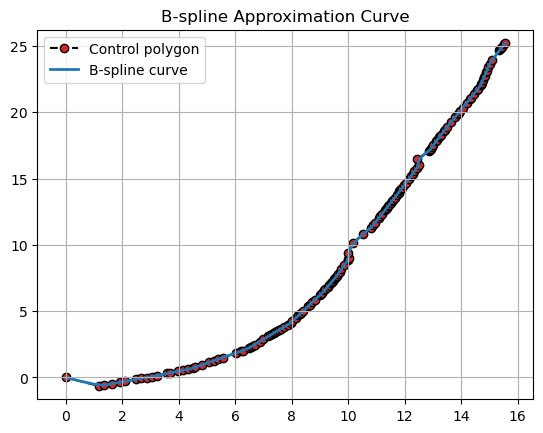

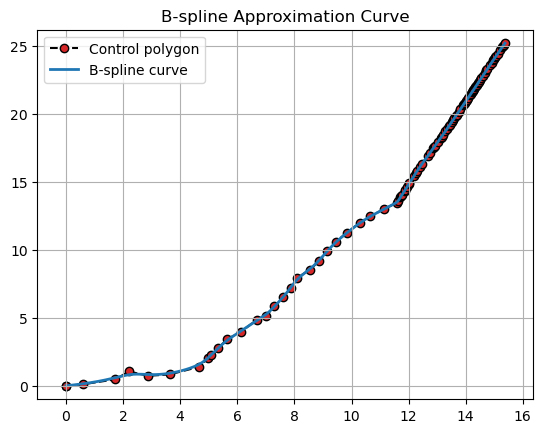

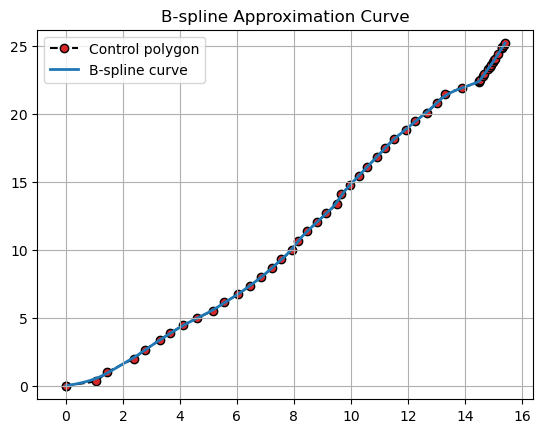

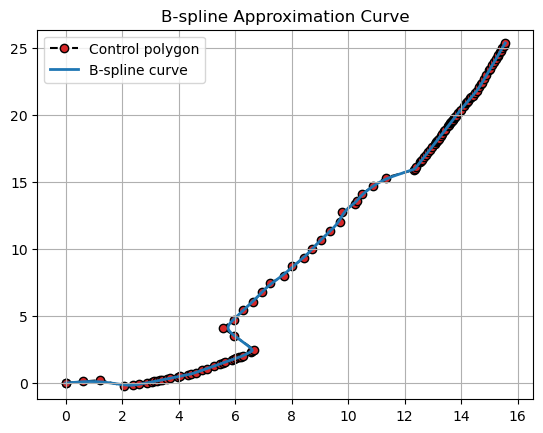

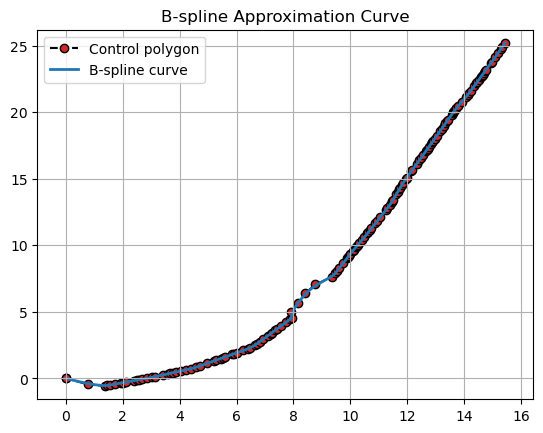

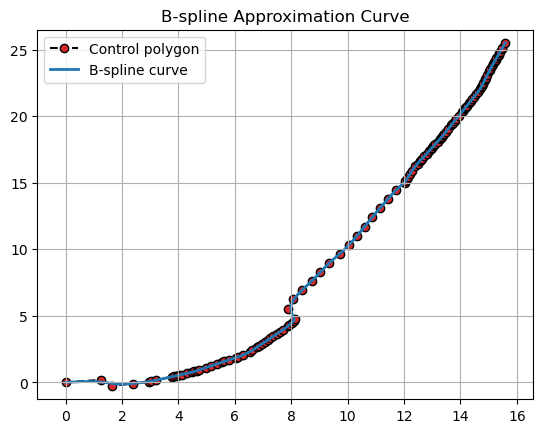

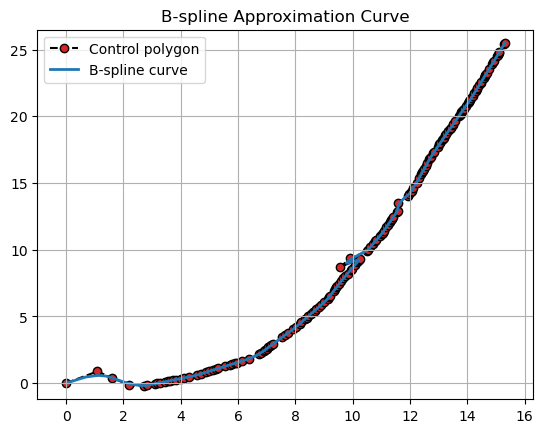

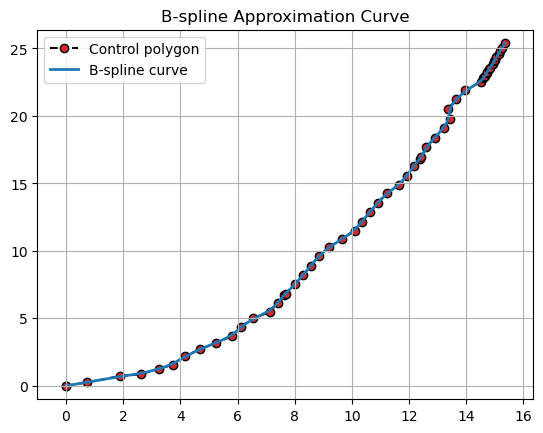

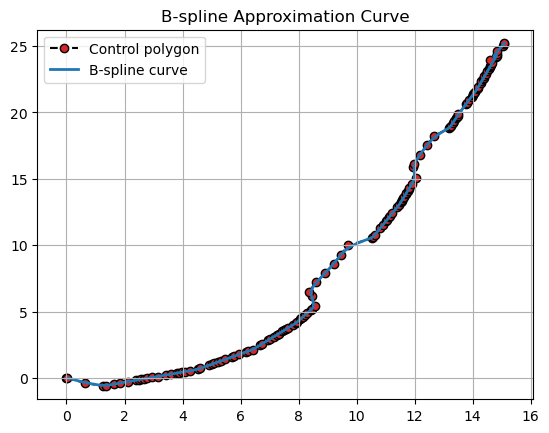

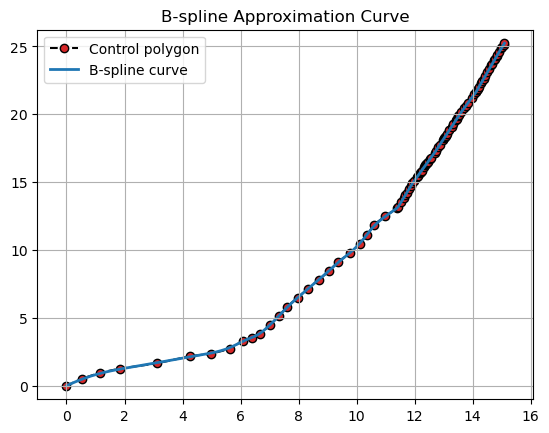

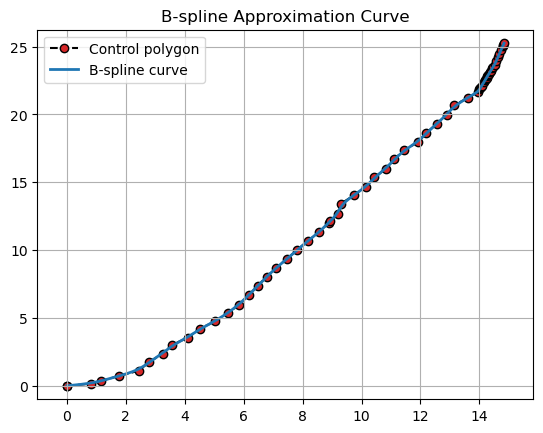

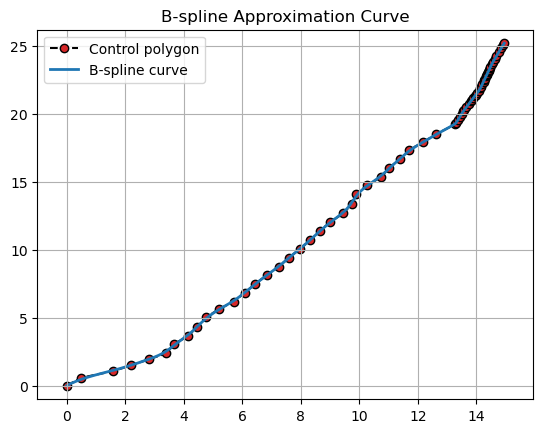

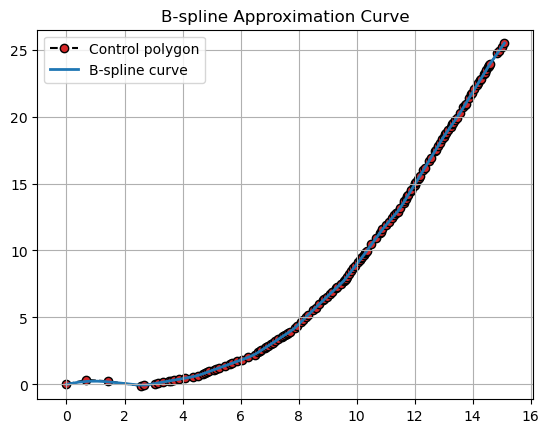

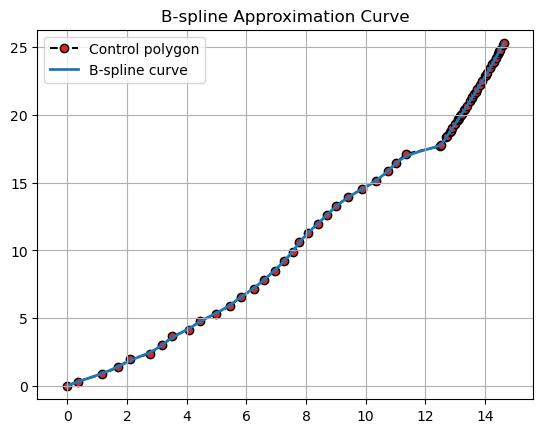

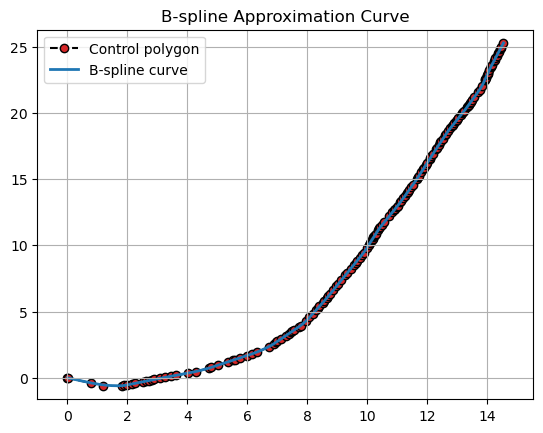

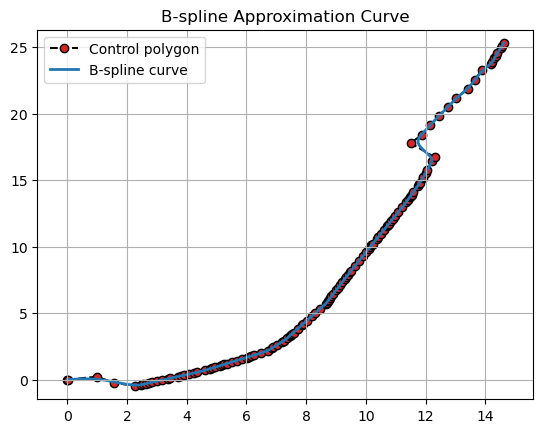

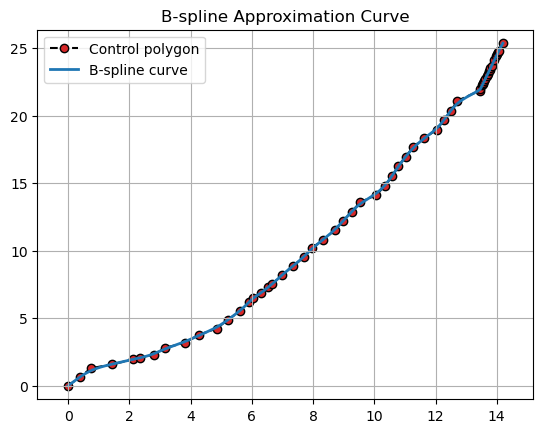

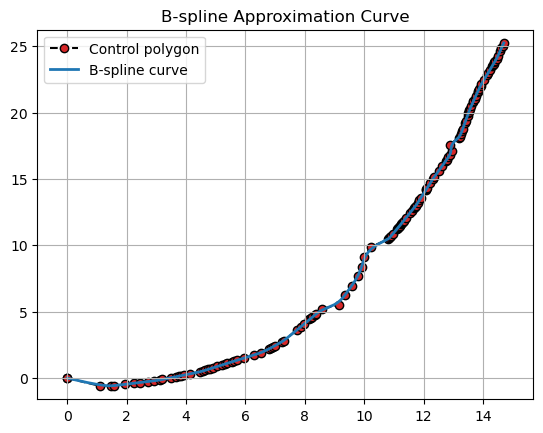

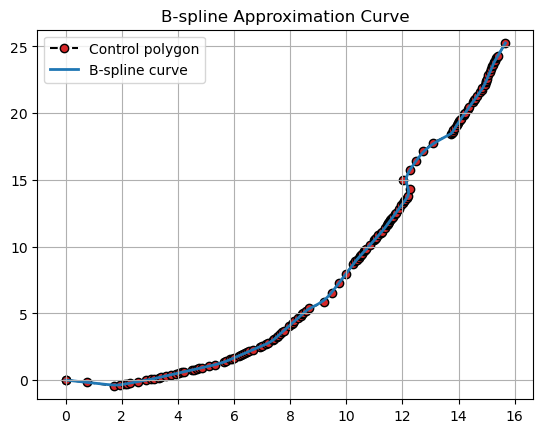

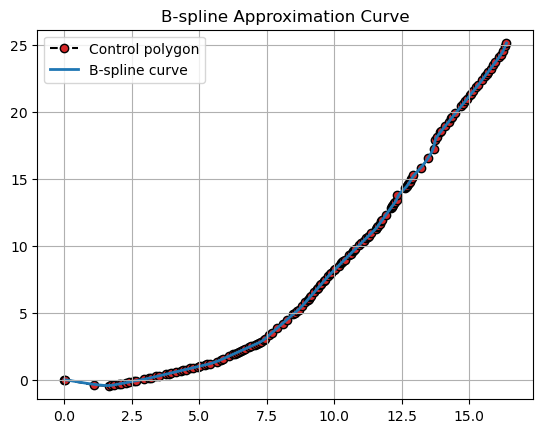

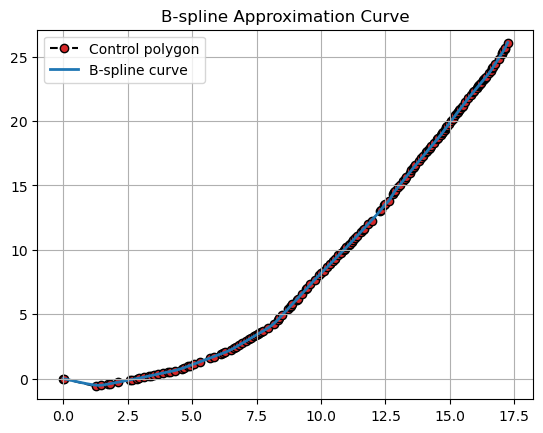

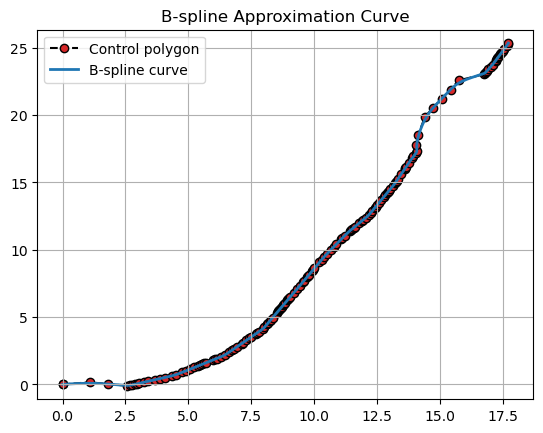

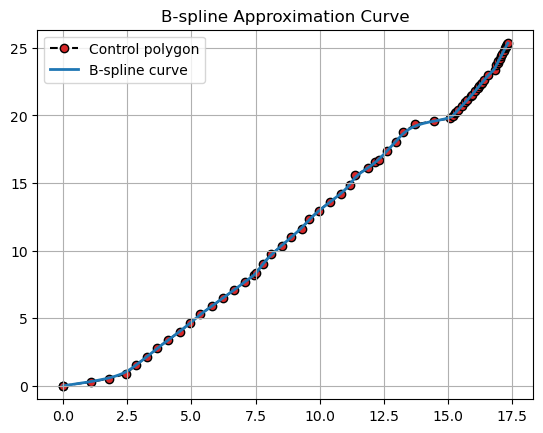

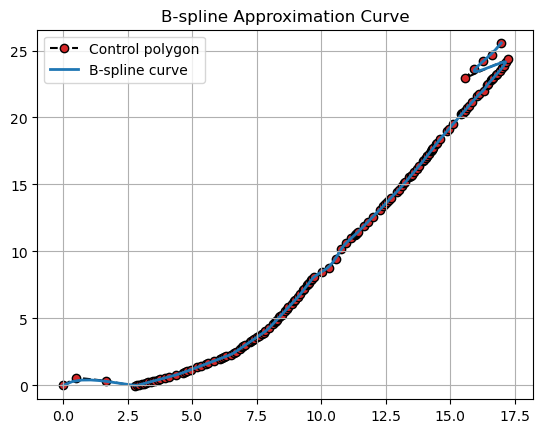

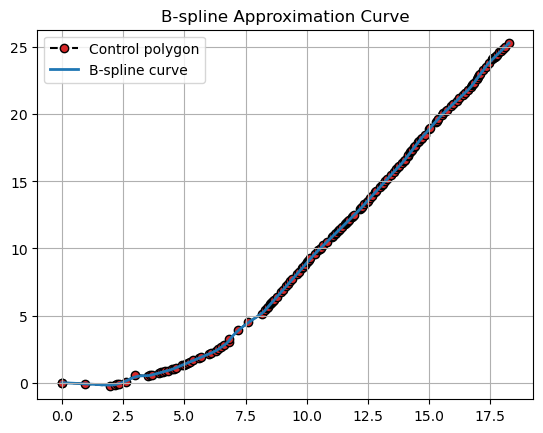

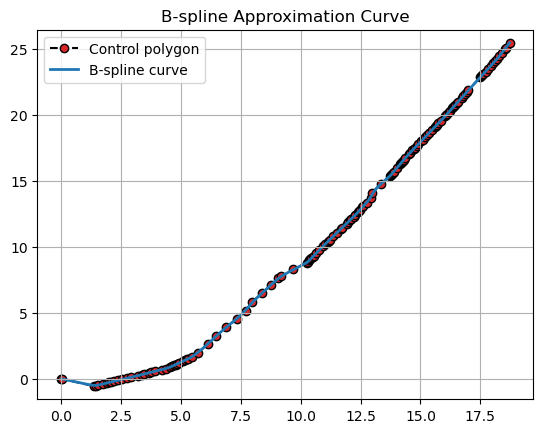

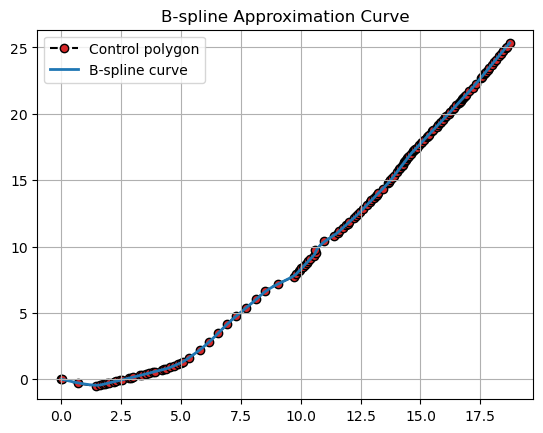

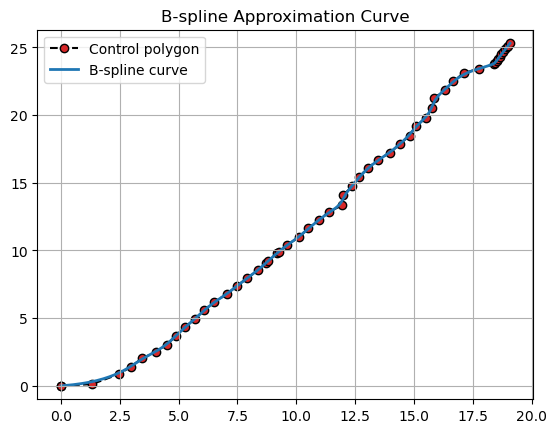

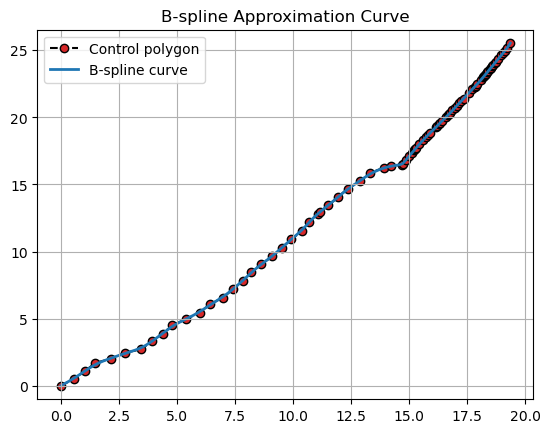

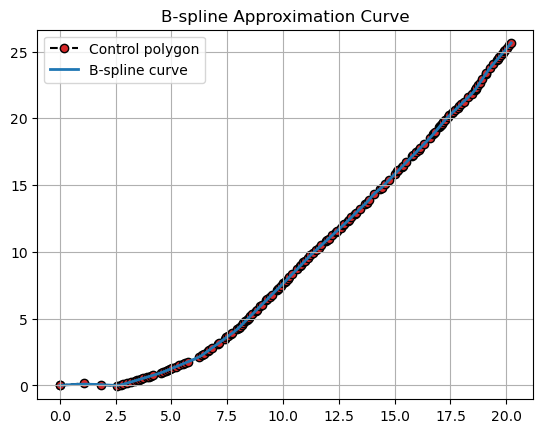

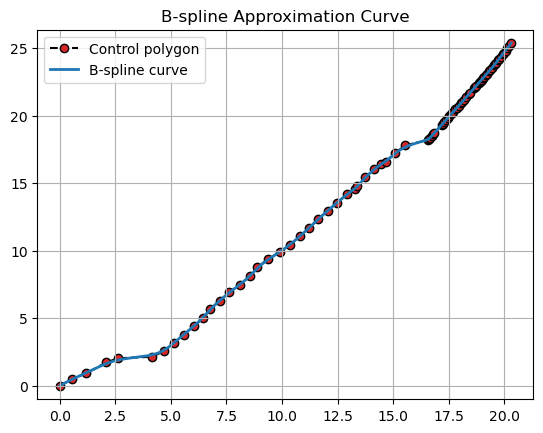

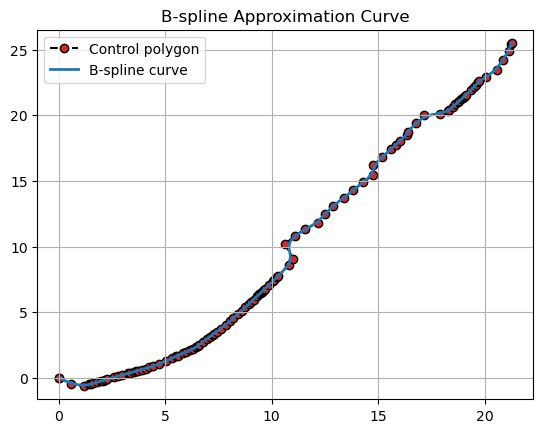

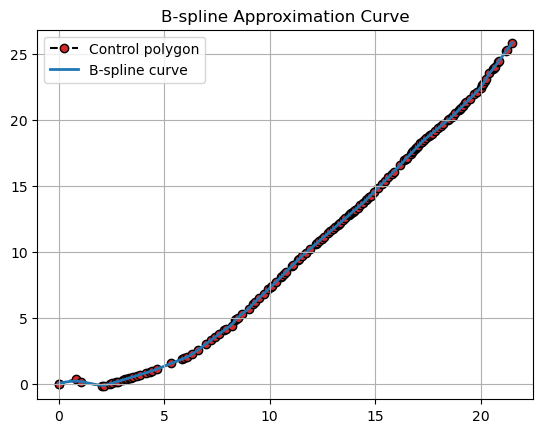

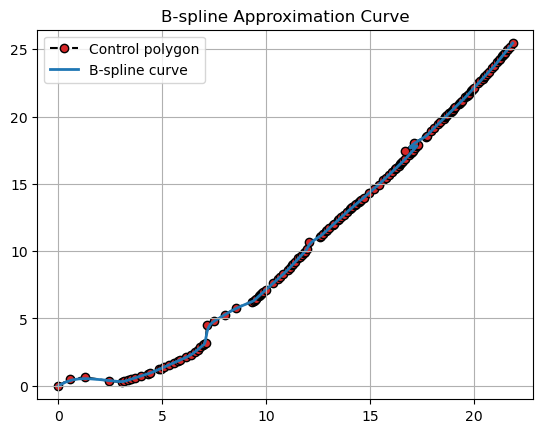

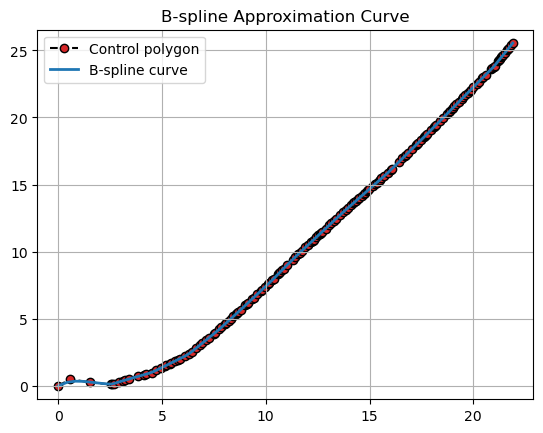

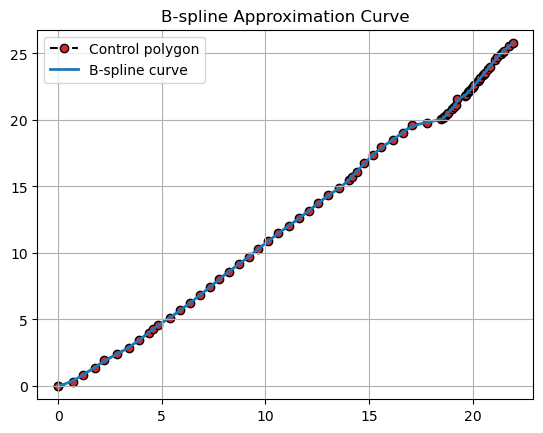

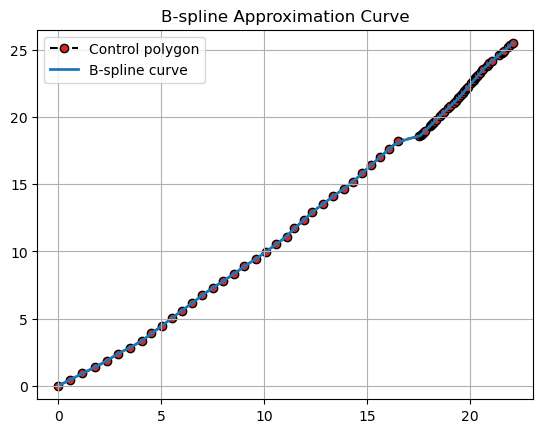

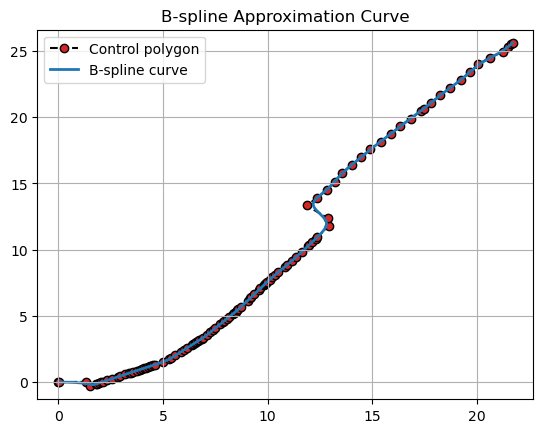

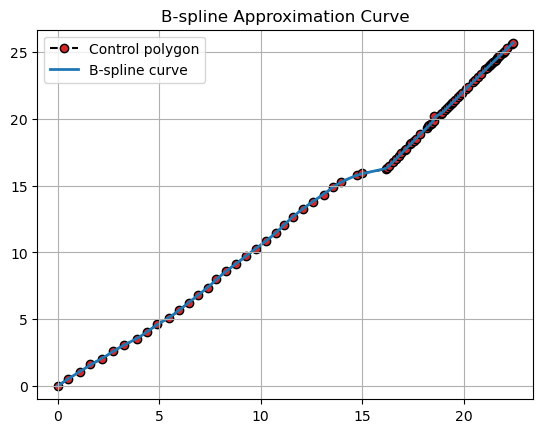

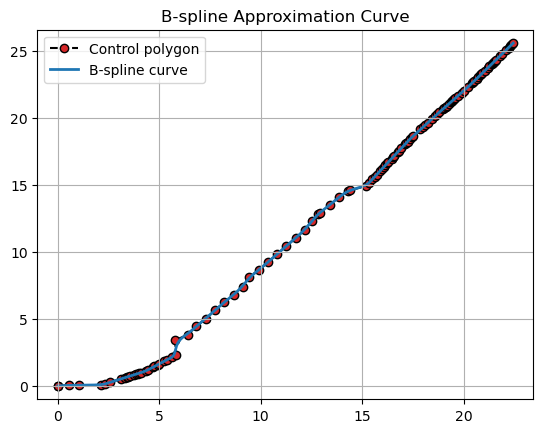

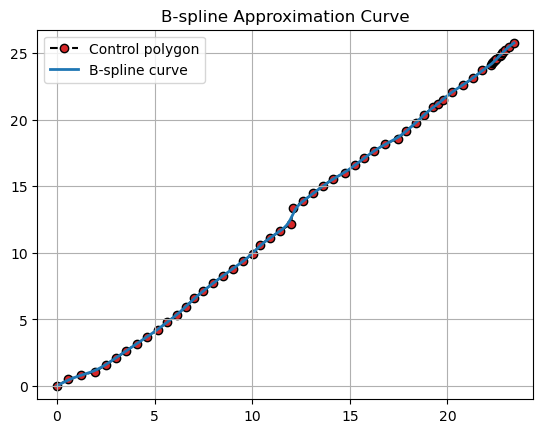

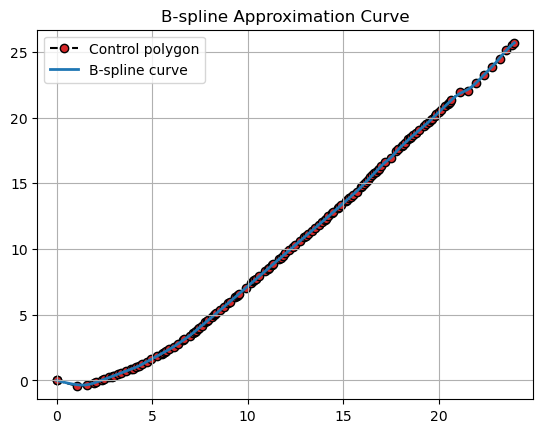

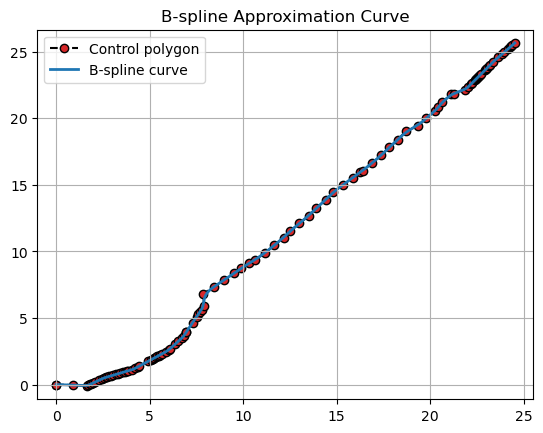

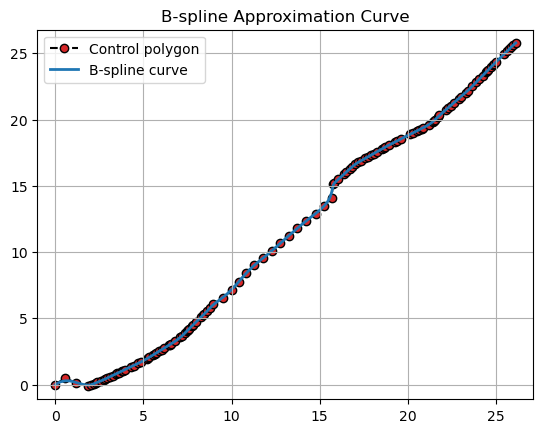

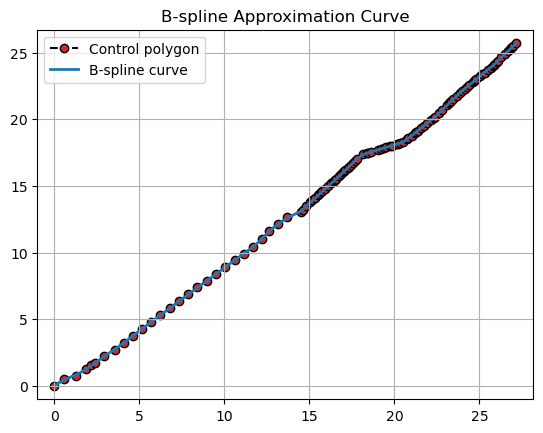

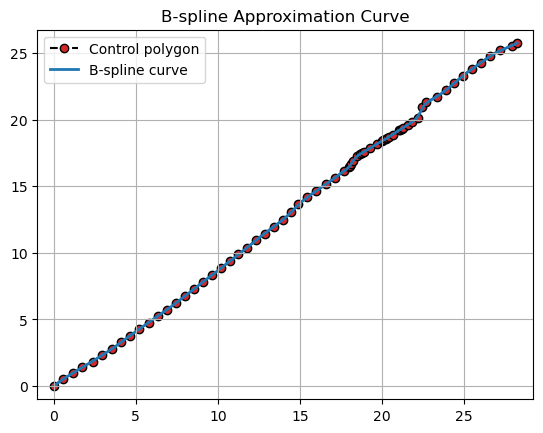

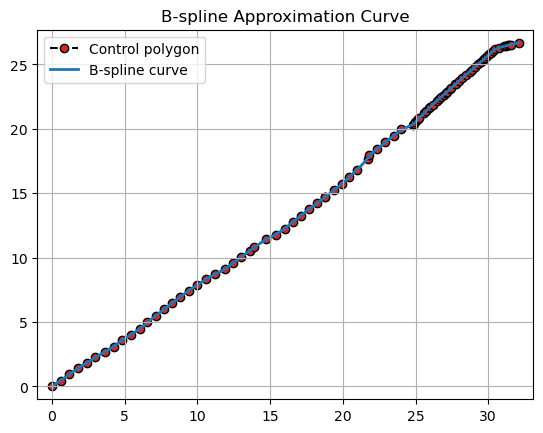

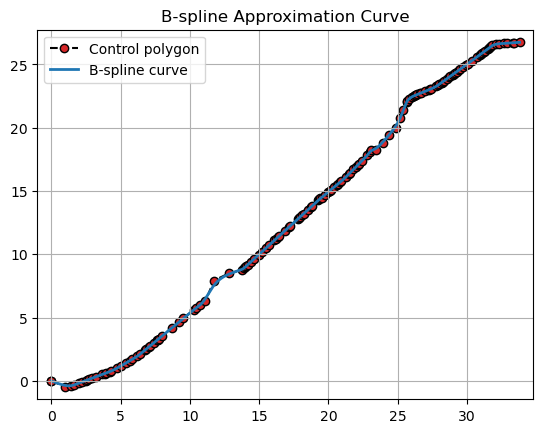

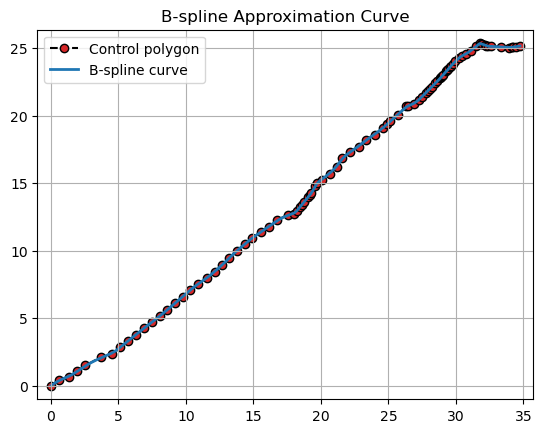

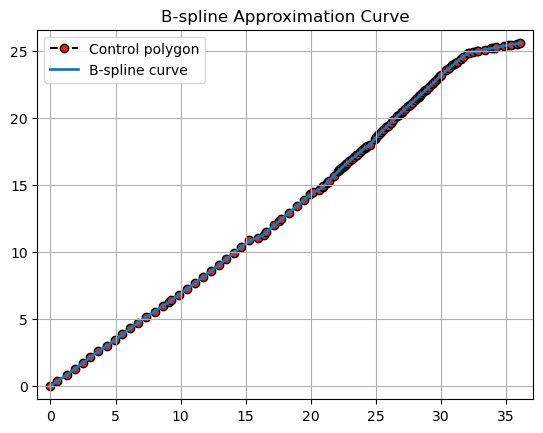

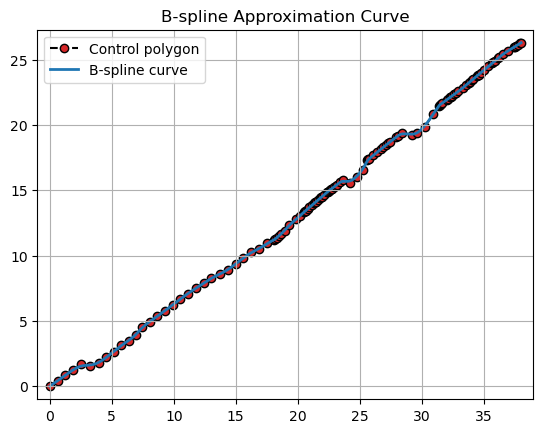

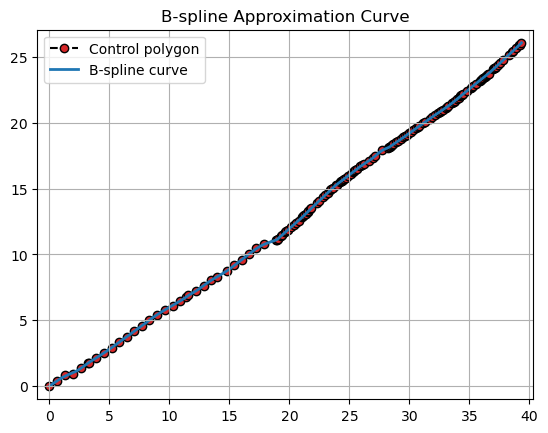

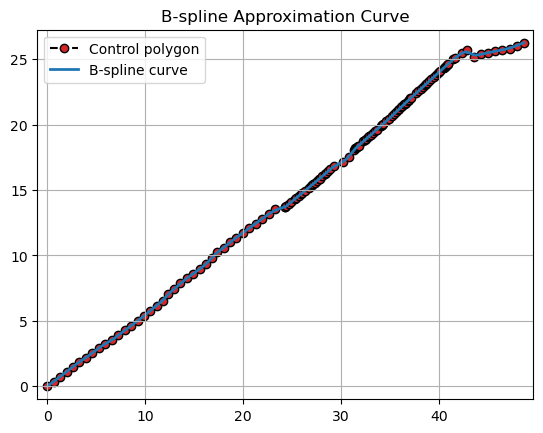

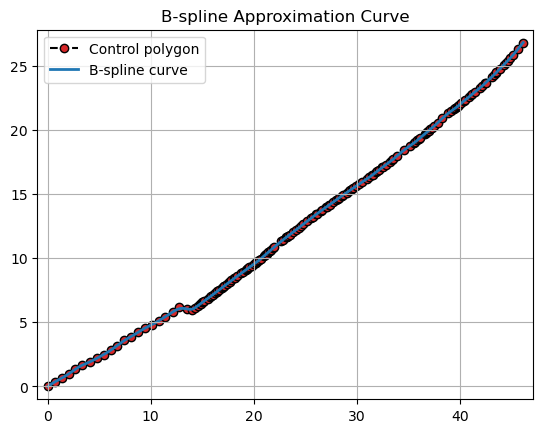

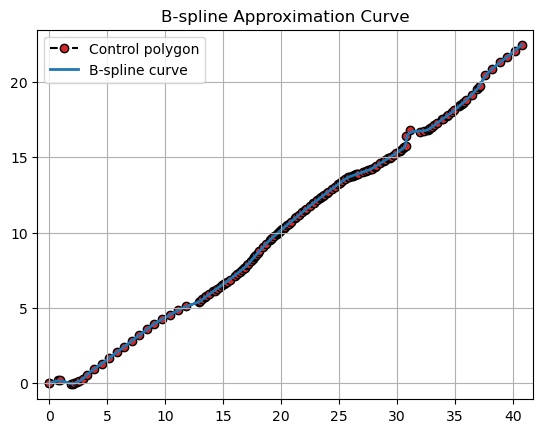

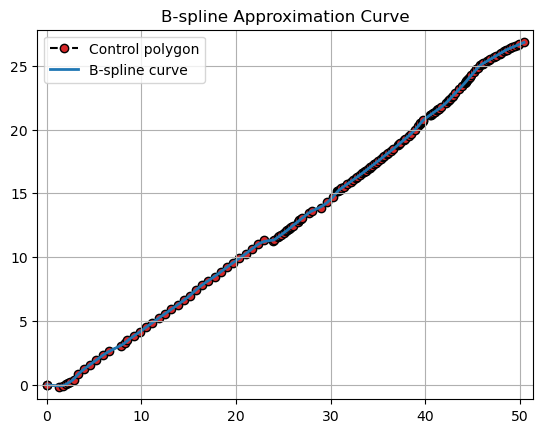

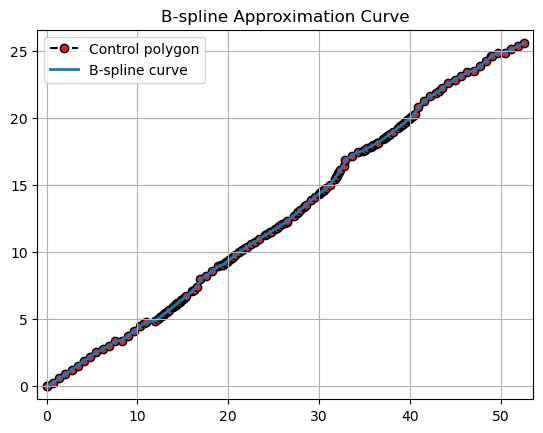

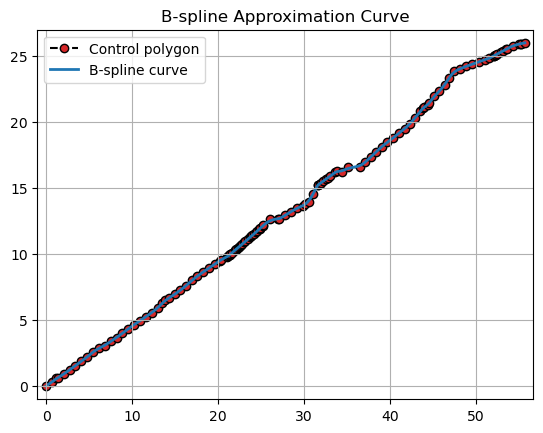

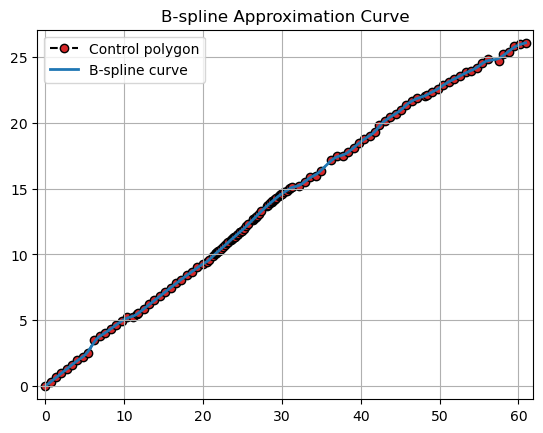

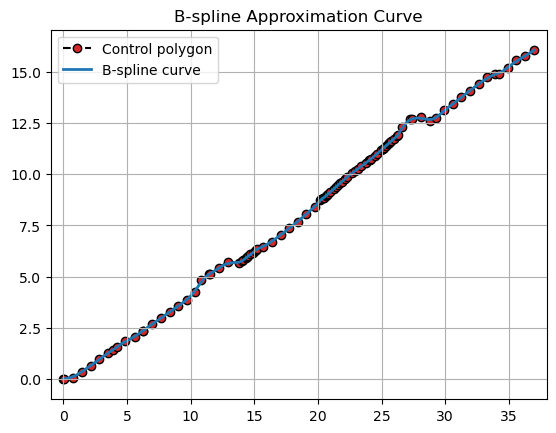

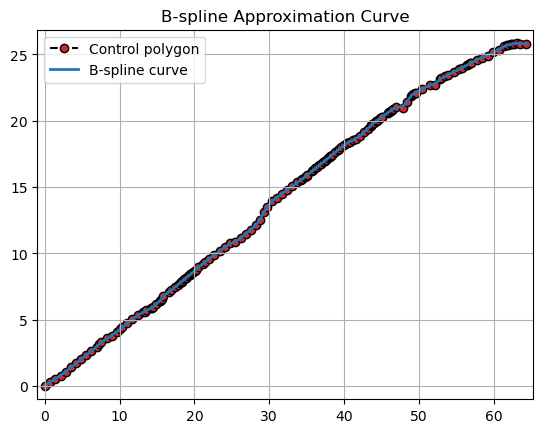

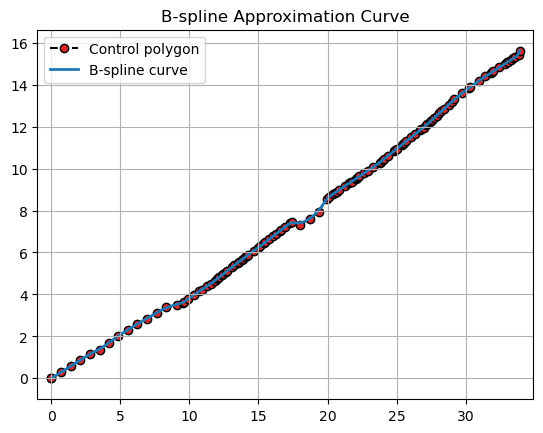

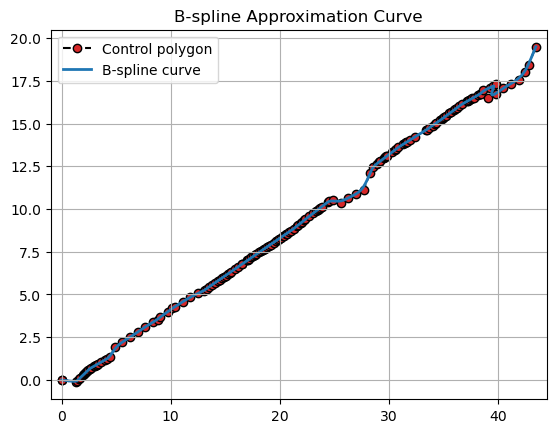

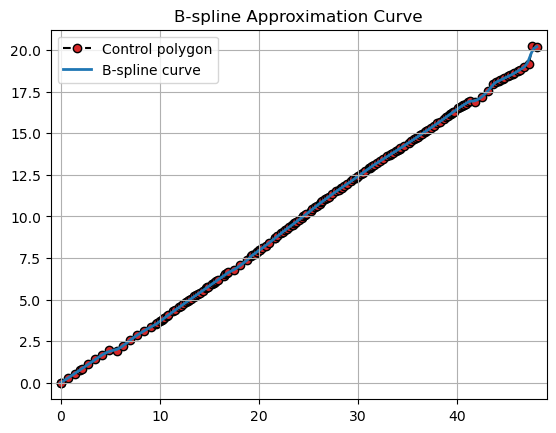

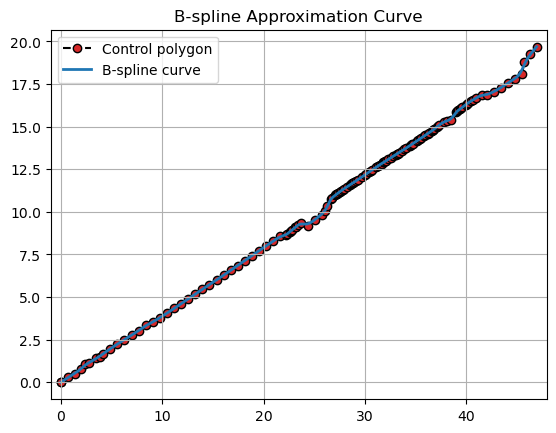

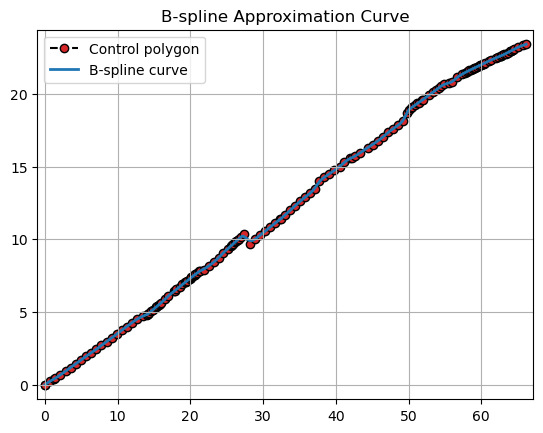

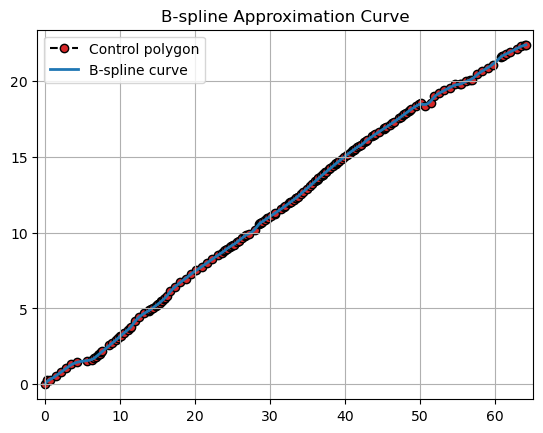

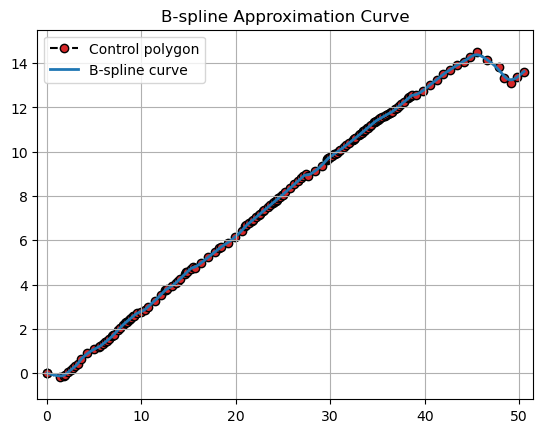

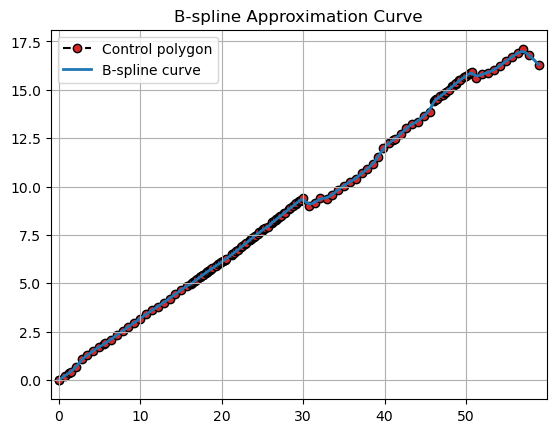

In [12]:
ctrs = []
for p in paths:
    coors = parseCoorsFromPathFile(os.path.join(pathsdir, p))
    ctr = np.array(coors)
    ctrN = ctr.copy()
    p = 5 #degree
    midpoints = [0]*(len(ctr)-1)
    
    ctr,inserted_ctr = createMidPoints(ctr,midpoints=midpoints)
    ctrs.append(ctr)
    bspline, curvature = getBSpline(ctr)
    plotPath(ctrN, inserted_ctr, bspline)

In [116]:
inserted_ctr

array([], dtype=float64)

In [140]:
from PathPlanning.Sampling_based_Planning.rrt_2D import rrt

In [148]:
import sys
sys.path.append(r"C:\Users\MaorKehati\Desktop\bspline\PathPlanning")
from PathPlanning.Sampling_based_Planning.rrt_2D import rrt, rrt_star

In [154]:
rrt.Rrt((0,0),(30,30)

TypeError: Rrt.__init__() missing 5 required positional arguments: 's_start', 's_goal', 'step_len', 'goal_sample_rate', and 'iter_max'

In [1]:
from scipy.interpolate import dfitpack

In [21]:
dir(dfitpack.curfit)

['__call__',
 '__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [86]:
out = r"C:\Users\MaorKehati\Desktop\dierckxpp-master\out.txt"

In [88]:
with open(out,'r') as fh:
    outc = fh.read()

In [138]:
se, si = 0,0
d={}

while se >= 0:
    se = outc.find('NN:',si+1)
    a = outc[si:se]
    si = se

    nn = int(a[:a.find("\n")].replace("NN: ",""))
    a = [i.split(" ") for i in a.split("\n")[1:] if i]
    a = [(float(i[2]),float(i[5])) for i in a if not i[0].startswith("NN:")]
    a = np.array(a)
    d[nn]=a


In [ ]:
return cmap of two color gradients in hex\n",
    def gradient(color1,color2,l):\n",
        assert color1[0] == color2[0] == \"#\"\n",
        f\"{42:#0{8}x}\"\n",
        return [\"#\"+\n",
                f\"{round(int(color1[1:3],16)*(1-x)+int(color2[1:3],16)*x):#0{4}x}\"[2:]
                f\"{round(int(color1[3:5],16)*(1-x)+int(color2[3:5],16)*x):#0{4}x}\"[2:]
                f\"{round(int(color1[5:7],16)*(1-x)+int(color2[5:7],16)*x):#0{4}x}\"[2:]
                for x in [i/(l-1) for i in range(l)]]

In [150]:
list(d.keys())[::15]

[151, 136, 121, 106, 91, 76, 61, 46, 31, 16]

In [174]:
def gradient(color1,color2,l):
    assert color1[0] == color2[0] == "#"
    f"{42:#0{8}x}"
    return ["#"+
    f"{round(int(color1[1:3],16)*(1-x)+int(color2[1:3],16)*x):#0{4}x}"[2:]+
    f"{round(int(color1[3:5],16)*(1-x)+int(color2[3:5],16)*x):#0{4}x}"[2:]+
    f"{round(int(color1[5:7],16)*(1-x)+int(color2[5:7],16)*x):#0{4}x}"[2:]
    for x in [i/(l-1) for i in range(l)]]

['#ff0000', '#ff4000', '#ff8000', '#ffbf00', '#ffff00']

0.0 14.5 0.0 0.0136174


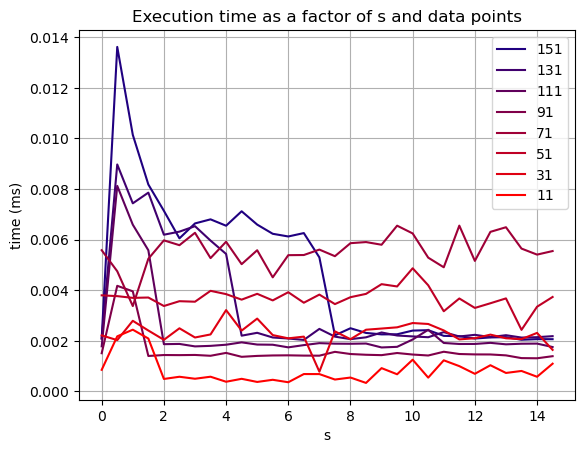

In [284]:
#cmap = matplotlib.colormaps['winter']
f, ax = plt.subplots()

dk = list(d.keys())[::20]
mnx, mny = np.inf, np.inf
mxx,mxy = 0, 0
colors = gradient("#200080","#ff0000",len(dk))
for ni,nn in enumerate(dk):
    plt.plot(d[nn][:,0], d[nn][:,1]*100., label=nn, color=colors[ni])
    mnx = min(min(d[nn][:,0]),mnx)
    mny = min(min(d[nn][:,1]),mnx)
    mxx = max(max(d[nn][:,0]),mxx)
    mxy = max(max(d[nn][:,1]),mxy)
    
mny, mxy = mny*100, mxy*100

print(mnx,mxx,mny,mxy)

plt.ylabel('time (ms)')
plt.xlabel('s')
plt.title(f'Execution time as a factor of s and data points')
#plt.text(0.6, 0.8, "# Data Points", fontsize=12, ha='left', va='top', transform=ax.transAxes)
#plt.xlim(mnx,mxx)
#plt.ylim(mny,mxy)
plt.legend(loc='upper right')
plt.grid()

array([[0.00000e+00, 6.89460e-05],
       [5.00000e-01, 1.58810e-04],
       [1.00000e+00, 1.10423e-04],
       [1.50000e+00, 9.11940e-05],
       [2.00000e+00, 8.90560e-05],
       [2.50000e+00, 6.64110e-05],
       [3.00000e+00, 7.50020e-05],
       [3.50000e+00, 6.71150e-05],
       [4.00000e+00, 6.79840e-05],
       [4.50000e+00, 7.54320e-05],
       [5.00000e+00, 6.96050e-05],
       [5.50000e+00, 6.33310e-05],
       [6.00000e+00, 6.44470e-05],
       [6.50000e+00, 6.09250e-05],
       [7.00000e+00, 5.12810e-05],
       [7.50000e+00, 2.25660e-05],
       [8.00000e+00, 2.16680e-05],
       [8.50000e+00, 2.18530e-05],
       [9.00000e+00, 2.21120e-05],
       [9.50000e+00, 2.17350e-05],
       [1.00000e+01, 2.17180e-05],
       [1.05000e+01, 2.75490e-05],
       [1.10000e+01, 2.38580e-05],
       [1.15000e+01, 2.18580e-05],
       [1.20000e+01, 2.12840e-05],
       [1.25000e+01, 2.19960e-05],
       [1.30000e+01, 2.14210e-05],
       [1.35000e+01, 2.09270e-05],
       [1.40000e+01,